In [189]:
import numpy as np
import pandas as pd
from pcse.db import NASAPowerWeatherDataProvider
import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm


In [190]:
grid_width = 1
grid_height = 1
duration = 365

In [287]:
paramVariete = {
                # # récupérés depuis HV42 parameters
                "TBase":10,
                "TOpt1":25,
                "TOpt2":35,
                "TLim":40,

                "VRacBVP":15.0,
                "VRacPSP":15.0,
                "VRacRPR":15.0,
                "VRacMatu1":8.0,
                "VRacMatu2":8.0,

                "SDJLevee":50,
                "SDJBVP":300, # 400
                "SDJRPR":300, # 400
                "SDJMatu1":300, # 400
                "SDJMatu2":50,

                "kcMax":1.2,
                "PFactor":0.5,
                "seuilCstrMortality":3,
                # "PPSens":0.7,

                'txAssimMatu1':1,
                'txAssimMatu2':0.5,

                'txConversion':4, # 4 pour C4, 6 pour C4
                'kdf': 0.5, # Light extinction and conversion

                "tempMaint":25,
                "txResGrain":0.5,
                "poidsSecGrain":0.028,
                "aeroTotPente":1E-5,
                "aeroTotBase":0.6,

                "pcReallocFeuille":0.7,
                "feuilAeroBase":0.6,

                "KRdtPotA": 0.4,
                "KRdtPotB": 200,

                "txRealloc":0.5,
                # "slaMax":0.0060,
                # "slaMin":0.0018,
                "slaBVP":0.003,
                "slaRPR":0.003,
                

                # # pas dans le fichier de params
                "VRacLevee":15.0, # pas dans les params
                'txAssimBVP':1,
                "txRespMaint":0.2, # ????
                "feuilAeroPente":1E-5, #???
                "KRdtBiom":10, #?????
                "KpenteSla":1,

                # # à vérifier
                "phaseDevVeg":4,
                "kBaseLaiDev":0.1,
                "kPenteLaiDev":0.5,
                "PPExp" : 0.1,
                "PPsens" : 0.4,
                "SeuilPP" : 13.5,
                "PPCrit": 12,

                "densiteA":0.4,
                "densiteP":0.7,
                
                }

paramITK = {
            "humSatMc":0, # humidité des résidus de couverture ?
            "biomIniMc":10, # Biomasse des résidues de couverture (Mulch). Unités : kg/ha
            "profRacIni":1, # mm
            "irrigAuto":False,
            "irrigAutoTarget":0.5,
            "maxIrrig":20,
            # "precision":0.1,
            "surfMc":0.0,
            "seuilEauSemis":0, # 5
            "mulch":10, # en pct integer [0-100]
            "coefMc":1,
            "nbjTestSemis":3,
            "seuilCstrMortality":10,
            "dateFin":300,
            "densite":5000,
            "densOpti":5000,
            }

paramTypeSol = {
                "ru":100, # en mm/m 
                "epaisseurSurf": 200, # en mm
                "epaisseurProf" : 1,
                "stockIniSurf":5,
                "stockIniProf":0.5,
                "seuilRuiss":1, # qté d'eau à partir de laquelle on entre dans un régime de ruissellement (mm)
                "pourcRuiss":0.5, # pourcentge de pluie qui ruisselle passé le seuil seuilRuiss (pct décimal)
                
                # 
                }

# ruRac = paramTypeSol["ru"] * paramITK["profRacIni"] / 1000 # alt name rRac
# ruSurf = paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]

In [192]:
 # getting weather data
weatherdata = NASAPowerWeatherDataProvider(longitude=5, latitude=52)
print(weatherdata)
df_weather = pd.DataFrame(weatherdata.export())
df_weather = df_weather[(df_weather["DAY"]>=datetime.date(2020,1,1)) & (df_weather["DAY"]<=datetime.date(2020,1,1)+datetime.timedelta(days=duration-1))]
df_weather.head()

df_weather["DOY"] = df_weather.apply(lambda x: x["DAY"].timetuple().tm_yday, axis=1)
df_weather["ET0"] = df_weather["ET0"] * 10 #conversion cm to mm

df_weather["RAIN"] = df_weather["RAIN"] #conversion cm to mm

Weather data provided by: NASAPowerWeatherDataProvider
--------Description---------
NASA/POWER CERES/MERRA2 Native Resolution Daily Data
----Site characteristics----
Elevation:    3.5
Latitude:  52.000
Longitude:  5.000
Data available for 1984-01-01 - 2022-07-03
Number of missing days: 1



ordre des modules depuis SarrahV42.docx

In [193]:
def InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration): # depuis Bileau.pas
    
    # BiomMc := BiomIniMc;
    data["biomMc"] = np.full((grid_width, grid_height, duration), paramITK["biomIniMc"])
    
    # LitTiges := BiomIniMc;
    data["litTiges"] = np.full((grid_width, grid_height, duration), paramITK["biomIniMc"])

    # StSurf := StockIniSurf;
    data["stSurf"] = np.full((grid_width, grid_height, duration), paramTypeSol["stockIniSurf"])

    # Ltr := 1;
    data["ltr"] = np.full((grid_width, grid_height, duration), 1)

    # StRurMax := Ru * ProfRacIni / 1000;
    data["stRurMax"] = np.full((grid_width, grid_height, duration), (paramTypeSol["ru"] * paramITK["profRacIni"] / 1000))

    # RuSurf := EpaisseurSurf / 1000 * Ru;
    data["ruSurf"] = np.full((grid_width, grid_height, duration), (paramTypeSol["epaisseurSurf"] / 1000 * paramTypeSol["ru"]))
    
    # //    PfTranspi := EpaisseurSurf * HumPf;
    # //    StTot := StockIniSurf - PfTranspi/2 + StockIniProf;

    # StTot := StockIniSurf  + StockIniProf;
    data["stTot"] = np.full((grid_width, grid_height, duration), (paramTypeSol["stockIniSurf"] + paramTypeSol["stockIniProf"]))
    
    # ProfRU := EpaisseurSurf + EpaisseurProf;
    data["profRu"] = np.full((grid_width, grid_height, duration), (paramTypeSol["epaisseurSurf"] + paramTypeSol["epaisseurProf"]))

    # // modif 10/06/2015  resilience stock d'eau
    # // Front d'humectation egal a RuSurf trop de stress initial
    # //    Hum := max(StTot, StRurMax);
    
    # Hum := max(RuSurf, StRurMax);
    # // Hum mis a profRuSurf
    # Hum := max(StTot, Hum);
    data["hum"] = np.full((grid_width, grid_height, duration),
        np.maximum(
            np.maximum(
                data["ruSurf"],
                data["stRurMax"],
            ),
            data["stTot"],
        )
    )
    
    # HumPrec := Hum;
    # StRurPrec := 0;
    # StRurMaxPrec := 0;
    # stRuPrec := stTot;
    # //modif 10/06/2015 resilience stock d'eau

    return data


In [194]:
def InitiationCulture(data, grid_width, grid_height, duration): # depuis MilBilanCarbone.pas
    

    # SommeDegresJourMaximale := SeuilTempLevee + SeuilTempBVP + SeuilTempRPR + SeuilTempMatu1 + SeuilTempMatu2;
    data["sommeDegresJourMaximale"] = np.full(
        (grid_width, grid_height, duration),
        (paramVariete["SDJLevee"] + paramVariete["SDJBVP"] + paramVariete["SDJRPR"] + paramVariete["SDJMatu1"] + paramVariete["SDJMatu2"])
    )

    # NumPhase := 0;
    # SommeDegresJour := 0;
    # BiomasseAerienne := 0;
    # BiomasseVegetative := 0;
    # BiomasseTotale := 0;
    # BiomasseTiges := 0;
    # BiomasseRacinaire := 0;
    # BiomasseFeuilles := 0;
    # DeltaBiomasseTotale := 0;
    # SeuilTempPhaseSuivante:=0;
    # Lai := 0;

    variables = [
        "numPhase",
        "sdj",
        "biomasseAerienne",
        "biomasseVegetative",
        "biomasseTotale",
        "biomasseTiges",
        "biomasseRacinaire",
        "biomasseFeuilles",
        "deltaBiomasseTotale",
        "seuilTempPhaseSuivante",
        "lai",
        
    ]

    for variable in variables :
        data[variable] = np.zeros(shape=(grid_width, grid_height, duration))

    return data

In [281]:
def InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol):

    variables = [
        "ddj",
        "phasePhotoper",
        "changePhase",

        "irrigation",
        "correctedIrrigation",
        "stockIrr",
        "ruIrr",
        "irrigTotDay",
        "eauDispo",
        "sommeIrrig",
        "stockMc",
        "eauCaptee",
        "lr",
        "ruRac",
        "vRac",
        "cstr",
        "dayVrac",
        "deltaRur",
        "stockRac",
        "stRuMax",
        "stockSurface",
        "stRuSurfPrec",
        "eauTranspi",
        "stockTotal",
        "dr",
        "fesw",
        "kce",
        "evapPot",
        "FEMcW",
        "evap",
        "ftsw",
        "kcp",
        "trPot",
        "pFact",
        "tr",
        "trSurf",
        "consoRur",
        "KAssim",
        "sommeDegresJourPhasePrec",
        "conv",
        "rdt",
        "biomasseTige",
        "biomasseFeuille",
        "sla",
        "parIntercepte",
        "assimPot",
        "assim",
        "dRespMaint",
        "biomTotStadeIp",
        "biomTotStadeFloraison",
        "rdtPot",
        "respMaint",
        "dRdtPot",
        "deltaBiomasseAerienne",
        "manqueAssim",
        "reallocation",
        "dayBiomLeaf",
        "deltaBiomasseFeuilles",
        "partFeuillesTiges",
        "bM",
        "cM",
        "sumPP",
        "seuilTempPhasePrec",
        "dureeDuJour",
        "nbJourCompte",
        "nbjStress",
        "rapDensite",
        "stRuSurf",
        "stRur",
        "humPrec",
        "stRurMaxPrec",
        "stRurPrec",
        "stRu",
        "stRurSurf",
        "stRuPrec",
        "stRuVar",
        "etp",
        "kcTot",
        "etr",
        "etm",

    ]

    for variable in variables :
        data[variable] = np.zeros(shape=(grid_width, grid_height, duration))

    data["tpMoy"] = df_weather["TEMP"].values.reshape(grid_width, grid_height, duration)
    data["rain"] = df_weather["RAIN"].values.reshape(grid_width, grid_height, duration)
    data["ET0"] = df_weather["ET0"].values.reshape(grid_width, grid_height, duration)
    data["rg"] = df_weather["IRRAD"].values.reshape(grid_width, grid_height, duration)
    

    data["ru"] = np.full((grid_width, grid_height, duration), paramTypeSol["ru"])
    data["irrigAuto"] = np.full((grid_width, grid_height, duration), paramITK["irrigAuto"])

    return data

In [196]:
def Meteo0DegToRad(): #pas indispensable
    return None

def Meteo1AVGTempHum(): # pas indispensable
    return None

def Meteo2Decli(): # pas indispensable
    return None

def Meteo3SunPosi():# pas indispensable
    return None

def Meteo4DayLength():# pas indispensable
    return None

def Meteo5SunDistance():# pas indispensable
    return None

def Meteo6RayExtra():# pas indispensable
    return None

def Meteo7RgMax():# pas indispensable
    return None

def Meteo8InsToRg():# pas indispensable
    return None

def Meteo9Par():# pas indispensable
    return None

def MeteoEToFAO():# pas indispensable
    return None



In [197]:
def EvalPhenoSarrahV3(j, data, paramITK): 
  
  """
  Traduit depuis phenologie.pas

  Cette procédure est appelée en début de journée et fait évoluer les phases
  phénologiques. Pour celà, elle incrémente les numéro de phase et change la
  valeur du seuil de somme de degré jours de la phase suivante.
  ChangePhase est un booléen permettant d'informer le modéle pour connaître
  si un jour est un jour de changement
  de phase. Celé permets d'initialiser les variables directement dans les
  modules spécifiques.
  Méthode générique pour le test de fin de la phase photopériodique.
  PhasePhotoper = 0 en fin de la phase photoper et = 1 en debut de la phase

  --> Stades phénologiques pour les céréales:
  // 0 : du jour de semis au début des conditions favorables pour la germination et de la récolte é la fin de simulation (pas de culture)
  // 1 : du début des conditions favorables pour la germination au jour de la levée
  // 2 : du jour de la levée au début de la phase photopériodique
  // 3 : du début de la phase photopériodique au début de la phase reproductive
  // 4 : du début de la phase reproductive au début de la maturation (seulement pour le mais et riz) Pas pris en compte ici!
  //      sousphase1  de début RPR é RPR/4
  //      sousphase2  de RPR/4 é RPR/2
  //      sousphase3 de RPR/2 é 3/4 RPR
  //      sousphase4 de 3/4 RPR é fin RPR
  // 5 : du début de la maturation au stade grain laiteux
  // 6 : du début du stade grain laiteux au jour de récolte
  // 7 : le jour de la récolte
  Dans le cas des simulations pluriannuelles en continue, on ne réinitialise pas les réservoirs, é la récolte on met le front d'humectation é la profndeur du réservoir de surface
  Cela permet de garder le phénoméne de contrainte d'enracinement pour la saison suivante s'il y a peu de pluie
  tout en ayant le stock d'eau en profondeur restant de la saison précédente.

  Args:
      j (int): numéro du jour depuis le début de la simulation
      data (dict): dictionnaire de matrices numpy
      paramITK (dict): dictionnaire de float

  Returns:
      dict: dictionnaire de matrices numpy
  """


  

  ###### Initialisation - test phase 0 - germination
  # on teste si on est à la phase 0 et que la quantité d'eau est suffisante
  condition = \
    (data["numPhase"][:,:,j] == 0) & \
    (data["stSurf"][:,:,j] - data["ruSurf"][:,:,j] / 10 >= paramITK["seuilEauSemis"])
  
  # on force alors le numéro de phase sur 1
  data["numPhase"][:,:,j:] = np.where(condition, 1, data["numPhase"][:,:,j])

  # on flag un changement de phase,
  # ce qui permet de déclencher la mise à jour de la somme de températures de la phase suivante
  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  # on force la somme de températures de la phase suivante sur le paramètre SDJ levée
  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
    condition,
    paramVariete["SDJLevee"],
    data["seuilTempPhaseSuivante"][:,:,j],
  )

  # on flag ce changement de phase comme étant celui de l'initiation
  # ce qui permet plus tard de bypasser l'incrémentation du numéro de phase
  data["initPhase"] = data["numPhase"] * 0
  data["initPhase"][:,:,j:] = np.where(
    condition,
    1,
    data["initPhase"][:,:,j]
  )
  
 

  ###### Marquage des dates de changement de phase
  ### Test phase 2
  condition = \
    (data["numPhase"][:,:,j] == 2) & \
    (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])

  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  ### Test phases 1, 4, 5, 6
  condition = \
    (data["numPhase"][:,:,j] != 0) & \
    (data["numPhase"][:,:,j] != 2) & \
    (data["numPhase"][:,:,j] != 3) & \
    (data["sdj"][:,:,j] >= data["seuilTempPhaseSuivante"][:,:,j])

  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  ### test phase 3
  condition = \
    (data["numPhase"][:,:,j] == 3) & \
    (data["phasePhotoper"][:,:,j] == 0)

  data["changePhase"][:,:,j] = np.where(condition, 1, data["changePhase"][:,:,j])

  
  
  ###### incrémentation de la phase
  condition = \
    (data["numPhase"][:,:,j] != 0) & \
    (data["changePhase"][:,:,j] == 1) & \
    (data["initPhase"][:,:,j] != 1)  

  data["numPhase"][:,:,j:] = np.where(
    condition,
    data["numPhase"][:,:,j] + 1 ,
    data["numPhase"][:,:,j],
  )

  # on enregistre les sdj de la phase précédente
  data["sommeDegresJourPhasePrec"][:,:,j:] = np.where(
      condition,
      data["seuilTempPhaseSuivante"][:,:,j],
      data["sommeDegresJourPhasePrec"][:,:,j],
  )



  ### on met à jour les températures de changement de phase
  # phase 1
  condition = \
    (data["numPhase"][:,:,j] == 1) & \
    (data["changePhase"][:,:,j] == 1)

  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      condition,
      paramVariete["SDJLevee"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )

  # phase 2
  condition = \
    (data["numPhase"][:,:,j] == 2) & \
    (data["changePhase"][:,:,j] == 1)

  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      condition,
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJBVP"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )

  # phase 3
  condition = \
    (data["numPhase"][:,:,j] == 3) & \
    (data["changePhase"][:,:,j] == 1)

  data["phasePhotoper"][:,:,j] = np.where(
      condition,
      1,
      data["phasePhotoper"][:,:,j],
  )  

  # phase 4
  condition = \
    (data["numPhase"][:,:,j] == 4) & \
    (data["changePhase"][:,:,j] == 1)

  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      condition,
      data["sdj"][:,:,j] + paramVariete["SDJRPR"],
      data["seuilTempPhaseSuivante"][:,:,j]
  ) 

  # phase 5
  condition = \
    (data["numPhase"][:,:,j] == 5) & \
    (data["changePhase"][:,:,j] == 1)

  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      condition,
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu1"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )

  # phase 6
  condition = \
    (data["numPhase"][:,:,j] == 6) & \
    (data["changePhase"][:,:,j] == 1)

  data["seuilTempPhaseSuivante"][:,:,j:] = np.where(
      condition,
      data["seuilTempPhaseSuivante"][:,:,j] + paramVariete["SDJMatu2"],
      data["seuilTempPhaseSuivante"][:,:,j]
  )                                                    

  # arrivés au stade 7, on remet les variables phénologiques principales à zero
  data["changePhase"][:,:,j] = np.where(data["numPhase"][:,:,j] == 7, 0, data["changePhase"][:,:,j])
  data["sdj"][:,:,j:] = np.where(data["numPhase"][:,:,j] == 7, 0, data["sdj"][:,:,j])
  data["numPhase"][:,:,j:] = np.where(data["numPhase"][:,:,j] == 7, 0, data["numPhase"][:,:,j])


  return data

In [198]:
def EvalDegresJourSarrahV3(j, data, paramVariete):
    
    """
    depuis phenologie.pas 
    
    Pb de méthode !?
    v1:= ((Max(TMin,TBase)+Min(TOpt1,TMax))/2 -TBase )/( TOpt1 - TBase);
    v2:= (TL - max(TMax,TOpt2)) / (TL - TOpt2);
    v:= (v1 * (min(TMax,TOpt1) - TMin)+(min(TOpt2,max(TOpt1,TMax)) - TOpt1) + v2 * (max(TOpt2,TMax)-TOpt2))/( TMax- TMin);
    DegresDuJour:= v * (TOpt1-TBase);

    Returns:
        _type_: _description_
    """

    #     If Tmoy <= Topt2 then
    #      DegresDuJour:= max(min(TOpt1,TMoy),TBase)-Tbase
    #   else
    #      DegresDuJour := (TOpt1-TBase) * (1 - ( (min(TL, TMoy) - TOpt2 )/(TL -TOpt2)));
    #    If (Numphase >=1) then
    #         SomDegresJour := SomDegresJour + DegresDuJour
    #    else SomDegresJour := 0;


    # calcul des degrés jour
    data["ddj"][:,:,j] = np.where(
        data["tpMoy"][:,:,j] <= paramVariete["TOpt2"],
        np.maximum(np.minimum(paramVariete["TOpt1"], data["tpMoy"][:,:,j]), paramVariete["TBase"]) - paramVariete["TBase"],
        (paramVariete["TOpt1"] - paramVariete["TBase"]) * (1 - ((np.minimum(paramVariete["TLim"], data["tpMoy"][:,:,j]) - paramVariete["TOpt2"]) / (paramVariete["TLim"] - paramVariete["TOpt2"]))),
    )  

    # calcul de la somme de degré jour
    data["sdj"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] >= 1,
        data["sdj"][:,:,j] + data["ddj"][:,:,j],
        0,
    )

    return data


In [199]:
def EvalIrrigPhase(j, data, paramITK):
    """
    depuis bileau.pas

    CB 2014
Modification due � la prise en compte effet Mulch
  Soit on a une irrigation observ�e, soit on calcul la dose d'irrigation
  Elle est calcul�e en fonvtion d'un seuil d'humidit� (IrrigAutoTarget)
  et de possibilit� technique ou choix (MaxIrrig, Precision)
  Dans cette gestion d'irrigation la pluie du jour n'est pas prise en compte

    """
    # EnPlus : Double;
    # CorrectedIrrigation : Double;
    # StockIrr , RuIrr : Double;
    # IrrigTotDay := 0;
    # ces variables sont reset à chaque call de la fonction

    data["correctedIrrigation"][:,:,j] = data["irrigation"][:,:,j]

    # si on est en mode d'irrigation automatique
    # pour stockIrr
    # entre les phases 0 et 6, si la RU racinaire est inférieure à la RU desurface, 
    # autrement dit si les racines ne sont pas encore descendues en dessous del'horizon de surface,
    # le stockIrr vaut le stock de surface ; en somme, on met une borne minimaleau stockIrr.
    # Pour la phase 7, on conserve le stockIrr existant.

    condition = (data["irrigAuto"][:,:,j] == True) & \
        (data["numPhase"][:,:,j] > 0) & \
        (data["numPhase"][:,:,j] < 6)

    data["stockIrr"][:,:,j] = np.where(
        condition,
        np.where(
            (data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
            data["stRuSurf"][:,:,j],
            data["stockRac"][:,:,j],
            ),
        data["stockIrr"][:,:,j],
    )

    # pour ruIrr
    # même principe que pour stockIrr, concernant cette fois la réserve utile ;
    # on met donc une borne minimale au ruIrr.
    data["ruIrr"][:,:,j] = np.where(
        condition,
        np.where(
            (data["ruRac"][:,:,j] < data["ruSurf"][:,:,j]),
            data["ruSurf"][:,:,j],
            data["ruRac"][:,:,j],
            ),
        data["ruIrr"][:,:,j],
    )

    # pour irrigTotDay
    # entre les phases 0 et 6, si le rapport entre stockIrr et ruIrr est inférieur 
    # au irrigAutoTarget, autrement dit si le remplissage du réservoird'irrigation 
    # est en dessous du recherché, on rajoute 90% de la différence entre stockIrret ruIrr,
    # borné en minimum par 0 et en maximum par maxIrrig. On corrige cetteirrigation par
    # correctedIrrigation.
    # A noter le retrait de la méthode du calcul de l'arrondi selon la précisionrecherchée

    condition = (data["irrigAuto"][:,:,j] == True) & \
        (data["numPhase"][:,:,j] > 0) & \
        (data["numPhase"][:,:,j] < 6) & \
        (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])


    data["irrigTotDay"][:,:,j] = np.where(
        condition,
        np.minimum(
            np.maximum(
                0,
                ((data["ruIrr"][:,:,j] - data["stockIrr"][:,:,j]) * 0.9) - data["correctedIrrigation"][:,:,j]),
            paramITK["maxIrrig"]
        ),
        data["irrigTotDay"][:,:,j],
    )
    
    # On calcule l'irrigation totale du jour en sommant la correction d'irrigation et l'irrigTotDay
    data["irrigTotDay"][:,:,j] = data["correctedIrrigation"][:,:,j] + data["irrigTotDay"][:,:,j]		
   
    
    return data

In [200]:
def PluieIrrig(j, data):
    """
    d'après bileau.pas

    // CB 2014
Hypotheses :
Le mulch ajoute une couche direct sous la pluie et irrig, ici irrigTotDay
qui est l'irrigation observ�e ou calcul�e
d'o� on regroupe les deux avant calcul de remplissage du mulch et ensuite
calcul du ruissellement


    Fonction de calcul de l'eau totale apportée entre la pluie et l'irrigation.

    Args:
        j (_type_): _description_
        data (_type_): _description_

    Returns:
        _type_: _description_
    """

    data["eauDispo"][:,:,j] = data["rain"][:,:,j] + data["irrigTotDay"][:,:,j]
    return data

In [201]:
def RempliMc(j, data, paramITK):

    """
    d'après bileau.pas

    Hypotheses :
    � chaque pluie on estime la quantit� d'eau pour saturer le couvert
    on la retire � l'Eaudispo (pluie + irrig)
    On calcul la capacit� maximum de stockage fn de la biomasse et du taux de saturation
    rapport�e en mm (HumSatMc en Kg H2O/Kg biomasse)
    La pluie est en mm unit� :
    1 mm = 1 litre d'eau / m2
    1 mm = 10 tonnes d'eau / hectare = 10 000 kg/ha
    La biomasse est en kg/ha pour se rapporter � la quantit� de pluie capt�e en mm
    KgH2O/Kg Kg/ha et kg/m� on divise par 10 000
    ( pour 3000 kg/ha � HumSat 2.8 kgH2O/kg on a un stockage max de 0.84 mm de pluie !??)
    Cette capacit� a capter est fn du taux de couverture du sol calcul� comme le LTR
    SurfMc est sp�cifi� en ha/t (0.39), on rapporte en ha/kg en divisant par 1000
    On retire alors les mm d'eau capt�es � la pluie incidente.
    Le ruisselement est ensuite calcul� avec l'effet de contrainte du mulch

    eauDispo : Quantité journalière d'eau infiltrée dans le sol (moins le ruissellement). Unités : mm  


    Returns:
        _type_: _description_
    """

    # Var Eaucaptee : double;
    # eaucaptee est donc une variable remise à zero a chaque appel de fonction

    # eauCaptée
    # Détermination de l'eau captée par le mulch ; 
    data["eauCaptee"][:,:,j] = np.minimum(
        data["eauDispo"][:,:,j] * (1 - np.exp(-paramITK["surfMc"] * data["biomMc"][:,:,j] / 1000)),
        (paramITK["humSatMc"] * data["biomMc"][:,:,j]/ 10000) - data["stockMc"][:,:,j],
    )

    data["eauDispo"][:,:,j:] =  np.maximum(data["eauDispo"][:,:,j] - data["eauCaptee"][:,:,j], 0)
    data["stockMc"][:,:,j:] = data["stockMc"][:,:,j] + data["eauCaptee"][:,:,j]

    return data

In [202]:
def EvalRunOff(j, data, paramTypeSol):

    """
    d'après bileau.pas

    // CB 2014
    On a regroupé avant la pluie et l'irrigation (a cause de l'effet Mulch)
    si mulch on a enlevé l'eau captée
    oN CALCUL SIMPLEMENT LE RUISSELLEMENT EN FN DE SEUILS
    }
    """

    # lr est reset a zéro en début de calcul, on ne broadcast pas les valeurs
    data["lr"][:,:,j] = np.where(
        data["rain"][:,:,j] > paramTypeSol["seuilRuiss"],
        (data["eauDispo"][:,:,j]  - paramTypeSol["seuilRuiss"]) *  paramTypeSol["pourcRuiss"],
        data["lr"][:,:,j],
    )

    data["eauDispo"][:,:,j:] = data["eauDispo"][:,:,j] - data["lr"][:,:,j]

    return data

In [203]:

def EvolRurCstr2(j, data, paramITK):

    """
    d'après bileau.pas

    Modif 10/06/2015  Stres trop fort enracinement
    Trop d'effet de stress en tout début de croissance :
    1) la plantule a des réserves et favorise l'enracinement
    2) dynamique spécifique sur le réservoir de surface
    Cet effet stress sur l'enracinement ne s'applique que quand
    l'enracinement est supérieur é la profondeur du réservoir de surface.
    Effet stres a un effet sur la vitesse de prof d'enracinement au dessus
    d'un certain seuil de cstr (on augmente le cstr de 0.3
    pour que sa contrainte soit affaiblie sur la vitesse)
    La vitesse d'enracinement potentielle de la plante peut etre bloque
    par manque d'eau en profondeur (Hum). La profondeur d'humectation
    est convertie en quantite d'eau maximum equivalente
    // Parametres
    IN:
    Vrac : mm
    Hum : mm
    StRuSurf : mm
    RU : mm/m
    RuSurf : mm/m
    INOUT:
    stRurMax : mm ==== ruRac
    stRur : mm ==== stockRac

    nb : on remet le nom de variables de christian plutôt que celles de Mathieu
    """

    # dayvrac et deltarur reset à chaque itération ; on traine donc le j sur les autres variables

    # rurac partie 1 // stRurMax
    # réserve utile racinaire à l'initialisation
    # au changement de phase entre la phase 0 et la phase 1 (initiation),
    # la réserve utile racinaire est initialisée en multipliant la profondeur
    # racinaire initiale avec la RU du sol
    data["stRurMax"][:,:,j:] = np.where(
        (data["changePhase"][:,:,j] == 1) & (data["numPhase"][:,:,j] == 1),
        paramITK["profRacIni"] / 1000 * data["ru"][:,:,j],
        data["stRurMax"][:,:,j],
    )

    # dayVrac
    # on met à jour la vitesse de croissance racinaire
    # pour les phases à partir de 1 à l'exclusion de l'initiation pour laquelle on a
    # une réserve utile racinaire supérieure à la réserve utile de surface,
    # la vitesse racinaire est définie comme vRac modulée par le cstr modifié
    # on note qu'en début de simulation, vRac n'est pas encore défini expliquant une valeur nulle
    # 

    condition = (data["numPhase"][:,:,j] > 0) & \
            np.invert((data["numPhase"][:,:,j] == 1) & (data["changePhase"][:,:,j] == 1)) & \
            (data["stRurMax"][:,:,j] > data["ruSurf"][:,:,j])

    
    data["dayVrac"][:,:,j] = np.where(
        condition,
        (data["vRac"][:,:,j] * np.minimum(data["cstr"][:,:,j] + 0.3, 1.0)) / 1000 * data["ru"][:,:,j],
        data["vRac"][:,:,j] / 1000 * data["ru"][:,:,j], 
    )
    
    
    # deltarur 
    data["deltaRur"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] > 0) & \
            np.invert((data["numPhase"][:,:,j] == 1) & (data["changePhase"][:,:,j] == 1)),   
        np.where(
            (data["hum"][:,:,j] - data["stRurMax"][:,:,j]) < data["dayVrac"][:,:,j],
            data["hum"][:,:,j] - data["stRurMax"][:,:,j],
            data["dayVrac"][:,:,j],
        ),
        data["deltaRur"][:,:,j],
    )


    
    # rurac2
    data["stRurMax"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j]>0),
        np.where(
            np.invert((data["changePhase"][:,:,j] == 1) & (data["numPhase"][:,:,j] == 1)),
            data["stRurMax"][:,:,j] + data["deltaRur"][:,:,j],
            data["stRurMax"][:,:,j],
        ),
        data["stRurMax"][:,:,j],
    )
        
    #stockrac
    data["stRur"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 0) & np.invert((data["changePhase"][:,:,j] == 1) & (data["numPhase"][:,:,j] == 1)),
        np.where(
            (data["stRurMax"][:,:,j] > data["ruSurf"][:,:,j]),
            data["stRur"][:,:,j] + data["deltaRur"][:,:,j],
            np.maximum((data["stRur"][:,:,j] - data["ruSurf"][:,:,j] / 10) * (data["stRurMax"][:,:,j] / data["ruSurf"][:,:,j]), 0),
        ),
        data["stRur"][:,:,j],
    )
    

    return data

In [257]:
def rempliRes(j, data):

    # d'après bileau.pas
    #
    # Modif 10/06/2015 prise en compte de stock d'eau r�silient pour les simulation continues
    # Hypoth�se de la MAJ des stock en fn de l'eau r�siliente de l'ann�e pr�c�dente
    # dans le cas des simulations pluri annuelle en continue (NbAn = 1):
    # A la r�colte on recup�re les stock d'eau (StRuPrec), la prof d'Humectation (Humprec)
    # et la prof d'enracinement (stRurMaxprec). Pour le reservoir de surface on ne change rien.
    # On MAJ le stRu avec le stock de surface stRuSurf, Hum avec le max de remplissage de surface (RuSurf)
    # Si le StRu avec l'apport d'eau devinet sup au Hum
    # alors on tient compte dans cette augmentation du stock r�silient avec deux cas possible :
    # Si StRu est < � stRurMaxprec
    # alors on ajoute l'eau r�siliente contenue dans l'ancienne zone racinaire en fn
    # de la diff�rence de stock
    # Sinon on a de l'eau r�siliente au maximum de la CC jusqu'� l'ancienne HumPrec,
    # on rempli alors StRu de la diff�rence etre ces deux valeurs puis on fait la MAJ
    # des Dr, StRur, Hum etc...

    # Hypotheses :
    # On a une dynamique de l'eau represente par un remplissage par le haut
    # et une evolution des tailles de reservoirs quand ce remplissage est sup
    # a la quantite maximum de la taille en cours (front d'humectation).
    # Quand on a atteind la taille maximum par remplissage on considere
    # que c'est du drainage.
    # A l'interieur d'un reservoir l'eau est repartie de maniere homogene
    # (peu etre considere valable jusqu'a 2m de profondeur, dixit CB
    # d'apres d'autres sources).

    # 3 representation des reservoirs permettant de simuler 3 reservoirs:
    # 1)ensemble des reservoirs en eau, evoluant en profondeur en fonction
    # du front d'humectation
    # 2) reservoir de surface (taille fixe)ou s'effectue l'evaporation et une part de la
    # transpiration en presence de racines
    # Modif : on a ajoute l'evaporation en dessous du seuil Pf4.2 estime a
    # la moitie de la RU.
    # 3) reservoir contenant les racines, evoluant en fonction du front racinaire
    # REMARQUE : Ces reservoirs se chevauche
    # Au lieu de gerer des profondeurs on gere des stocks d'eau
    # (stRuMax stock d'eau maxi (RU * prof. Max)}

    # eautranspi est reset à chaque itération à 0
    # stRUmax est reset à la valeur ru à chaque itération
    # on ne cast donc pas ces variables sur j


    # reset
    # modif 10/06/2015 Resilience stock eau cas simul pluri en continue
    condition = (data["numPhase"][:,:,j] == 7) & (data["changePhase"][:,:,j] == 1)

    data["humPrec"][:,:,j:] = np.where(
        condition,
        np.maximum(data["hum"][:,:,j], data["ruSurf"][:,:,j]),
        data["humPrec"][:,:,j],
    )
    
    data["hum"][:,:,j:] = np.where(
        condition,
        data["ruSurf"][:,:,j],
        data["humPrec"][:,:,j],
    )

    data["stRurMaxPrec"][:,:,j:] = np.where(
        condition,
        data["stRurMax"][:,:,j],
        data["stRurMaxPrec"][:,:,j],
    )

    data["stRurPrec"][:,:,j:] = np.where(
        condition,
        data["stRur"][:,:,j]/data["stRurMax"][:,:,j],
        data["stRurPrec"][:,:,j],
    )

    data["stRuPrec"][:,:,j:] = np.where(
        condition,
        data["stRu"][:,:,j] - data["stRurSurf"][:,:,j],
        data["stRuPrec"][:,:,j],
    )



    # modif 10/06/2015 Resilience stock eau cas simul pluri en continue
    data["stRuMax"][:,:,j] = data["ru"][:,:,j] * data["profRu"][:,:,j] / 1000
    
    # Rempli Res surface
    # on met à jour le stock de surface
        # on cast sur j

    data["stRuSurfPrec"][:,:,j] = data["stRuSurf"][:,:,j]
    
    # on met à jour le stock d'eau en surface pour qu'il corresponde au stock de surface mis à jour
    # par l'eau disponible, borné au max par 110% de la réserve utile de surface.
    # on transmet donc la valeur sur j
    # ConsoResSep agit aussi sur cette variable
    data["stRuSurf"][:,:,j:] = np.minimum(
        data["stRuSurf"][:,:,j] + data["eauDispo"][:,:,j],
        data["ruSurf"][:,:,j] + data["ruSurf"][:,:,j] / 10
    )

    # // enleve la qte d'eau remplissant la partie uniquement evaporable
    # si le stock de surface à j-1 est inférieur à 10% de la réserve utile de surface, 
    # la quantité d'eau transpirable correspond à l'eau disponible moins la différence 
    # entre 1/10e de la réserve utile de surface et le stock de surface, bornée au minimum par 0,
    # sinon la quantité d'eau transpirable est égale à l'eau disponible
        # on cast sur j
    data["eauTranspi"][:,:,j] = np.where(
        data["stRuSurfPrec"][:,:,j] < data["ruSurf"][:,:,j]/10,
        np.maximum(
            0,
            data["eauDispo"][:,:,j] - (data["ruSurf"][:,:,j]/10 - data["stRuSurfPrec"][:,:,j])
            ),
        data["eauDispo"][:,:,j],
    )

    #// remplissage des autres r�servoirs
    #// rempli res en eau, estime drainage, et evolution du front d'humectation
    # on met à jour le stock d'eau total sur l'ensemble des réservoirs
    # en ajoutant l'eau transpirable
    # on transmet donc la valeur sur j
    data["stRu"][:,:,j:] = data["stRu"][:,:,j] + data["eauTranspi"][:,:,j]

    
    #// modif 10/06/2015 Resilience stock eau cas simul pluri en continue
    data["stRuVar"][:,:,j] = np.maximum(0, data["stRu"][:,:,j] - data["stRuPrec"][:,:,j])


    condition_1 = (data["stRuVar"][:,:,j] > data["hum"][:,:,j])
    condition_2 = (data["hum"][:,:,j] <= data["stRurMaxPrec"][:,:,j])
    condition_3 = (data["hum"][:,:,j] < data["humPrec"][:,:,j])

    data["stRu"][:,:,j:] = np.where(
        condition_1,
        np.where(
            condition_2,
            data["stRu"][:,:,j] + (data["stRuVar"][:,:,j] - data["hum"][:,:,j]) * data["stRurPrec"][:,:,j],
            np.where(
                condition_3,
                data["stRuVar"][:,:,j],
                data["stRu"][:,:,j],
            ),
        ),
        data["stRu"][:,:,j],
    )

    data["stRuPrec"][:,:,j:] = np.where(
        condition_1,
        np.where(
            condition_2,
            np.maximum(0, data["stRuPrec"][:,:,j] - (data["stRuVar"][:,:,j] - data["hum"][:,:,j]) * data["stRurPrec"][:,:,j]),
            np.where(
                condition_3,
                0,
                data["stRuPrec"][:,:,j],
            ),
        ),
        data["stRuPrec"][:,:,j],
    )

    data["stRuVar"][:,:,j:] = np.where(
        condition_1,
        np.where(
            condition_2,
            data["stRuVar"][:,:,j] + (data["stRuVar"][:,:,j] - data["hum"][:,:,j]) * data["stRurPrec"][:,:,j],
            np.where(
                condition_3,
                data["stRuVar"][:,:,j] + data["stRuPrec"][:,:,j],
                data["stRuVar"][:,:,j],
            ),
        ),
        data["stRuVar"][:,:,j],
    )


    data["hum"][:,:,j] = np.maximum(data["stRuVar"][:,:,j], data["hum"][:,:,j])

    # // modif 10/06/2015 Resilience stock eau cas simul pluri en continue
    # // modif 27/07/2016 Hum ne peut �tre au dessus de stRu (stocktotal)

    data["hum"][:,:,j] = np.minimum(data["stRuMax"][:,:,j], data["hum"][:,:,j])

    condition = (data["stRu"][:,:,j] > data["stRuMax"][:,:,j])

    data["dr"][:,:,j] = np.where(
        condition,
        data["stRu"][:,:,j] - data["stRuMax"][:,:,j],
        0,
    )

    data["stRu"][:,:,j] = np.where(
        condition,
        data["stRuMax"][:,:,j],
        data["stRu"][:,:,j],
    )

    # // avant modif 10/06/2015
    data["hum"][:,:,j] = np.maximum(data["hum"][:,:,j], data["stRu"][:,:,j])

    # // Rempli res racines
    data["stRur"][:,:,j] = np.minimum(data["stRur"][:,:,j] + data["eauTranspi"][:,:,j], data["stRurMax"][:,:,j])
    data["stRur"][:,:,j] = np.minimum(data["stRur"][:,:,j], data["stRu"][:,:,j])
    

    return data

In [260]:
def EvalFESW(j, data):
    """
    depuis bileau.pas

    Estimation de la fraction d'eau evaporable, rapporte donc au reservoir
    de surface, RuSurf est le stock d'eau maxi disponible pour la plante
    sur ce reservoir
    Modif : on considere que pour l'�vaporation la moitie de cette
    valeur doit etre ajout�e.
    // Parametres
    IN:
    StRusurf : mm
    RuSurf : mm
    OUT:
    fesw : mm
    """

    data["fesw"][:,:,j] = data["stRuSurf"][:,:,j] / (data["ruSurf"][:,:,j] + data["ruSurf"][:,:,j] / 10)

    return data

In [206]:
def EvalKceMc(j, data, paramITK):
    """
    depuis bileau.pas
    
    Trois possibilit�s d'extinction sur l'�vaporation :
    ltr : couverture de la plante
    Mulch : effet couvrant permanent et constant; 100 pas de Mulch, 0 couvert complet bache)
    exp() �quivalent � formule de calcul du ltr mais appliqu� � l'effet couvrant d'un
    mulch couvert de paillis... �volutif    
    """

    # Kce := Mulch/100 * ltr * exp(-coefMc * SurfMc * BiomMc/1000);
    data["kce"][:,:,j] = paramITK["mulch"] / 100 * data["ltr"][:,:,j] * np.exp(-paramITK["coefMc"] * paramITK["surfMc"] * data["biomMc"][:,:,j]/1000)
    
    return data

In [207]:
def DemandeSol(j, data):
    """
    depuis bileau.pas

    Estimation de l'evaporation potentielle du sol, on ne tient pas
    compte d'une variation de l'evaporation en fonction d'une humectation
    differente entre le haut et le bas du reservoir, on a un parametre
    mulch qui peu traduire le phenomene d'auto mulching (defaut : 0.7)
    qui peu aussi traduire un mulch par couverture vegetale ou...
    La reduction de l'evaporation par l'evolution de la couverture
    du sol par la plante est traduit par ltr.

    // Parametres
    IN:
    ETo : mm
    Kce : %
    OUT:
    evapPot : mm
    """
    data["evapPot"][:,:,j:] = data["etp"][:,:,j] * data["kce"][:,:,j]

    return data

In [261]:
def EvapMc(j, data, paramITK):
    """
    depuis bileau.pas

    comme pour FESW on retire du stock la fraction evaporable
    la demande climatique étant réduite é la fraction touchant le sol ltr
    on borne é 0
    """
    # on doit reset FEMcW à chaque cycle ?
    # Var FEMcW : double;

    data["FEMcW"][:,:,j] = np.where(
        data["stockMc"][:,:,j] > 0,
        (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
        data["FEMcW"][:,:,j],
    )

    data["stockMc"][:,:,j:] = np.maximum(
        0,
        data["stockMc"][:,:,j] - data["ltr"][:,:,j] * data["ET0"][:,:,j] * data["FEMcW"][:,:,j]**2,
    )

    return data

In [209]:
def EvapRuSurf(j, data):
    """
    depuis bileau.pas 

    Estimation de l'evaporation relle, rapporte a la fraction d'eau evaporable
    // Parametres
    IN:
    fesw : mm
    evapPot : mm
    stRuSurf : mm
    OUT:
    evap : mm
    """

    data["evap"][:,:,j:] = np.minimum(data["evapPot"][:,:,j] * data["fesw"][:,:,j]**2, data["stRuSurf"][:,:,j])

    return data


In [265]:
def EvalFTSW(j, data):
    """
    depuis bileau.pas 

    Estimation de la fraction d'eau transpirable, rapporte donc au reservoir
    contenant les racines
    // Parametres
    IN:
    RuRac : mm
    StockRac : mm
    OUT:
    ftsw : mm
    """

    data["ftsw"][:,:,j:] = np.where(
        data["ruRac"][:,:,j] > 0,
        data["stockRac"][:,:,j] / data["ruRac"][:,:,j],
        0,
    )

    return data

In [211]:
def EvolKcpKcIni(j, data, paramVariete):

    # //manque   Numphase := trunc(NoPhase); ??
    # d'après biomasse.pas : 
    # kcp := max ( 0.3,KcMax * (1 - Ltr));

    data["kcp"][:,:,j:] = np.maximum(0.3, paramVariete["kcMax"] * (1 - data["ltr"][:,:,j]))
    
    return data

In [212]:
def DemandePlante(j, data):
    # d'près bileau.pas
    # TrPot := Kcp * ETo;
    # attention, séparation de ETp et ET0 dans les formules
    data["trPot"][:,:,j:] = data["kcp"][:,:,j] * data["ET0"][:,:,j]
    
    return data

In [275]:
def EvalKcTot(j, data):
    # d'après bileau.pas

    data["kcTot"][:,:,j] = np.where(
        data["kcp"][:,:,j] == 0,
        data["kce"][:,:,j],
        data["kce"][:,:,j] + data["kcp"][:,:,j],
    )

    return data

In [214]:
def CstrPFactor(j, data, paramVariete):

    # d'après bileau.pas

    data["pFact"][:,:,j:] = paramVariete["PFactor"] + 0.04 * (5 - np.maximum(data["kcp"][:,:,j], 1) * data["etp"][:,:,j])
    data["pFact"][:,:,j:] = np.minimum(np.maximum(0.1, data["pFact"][:,:,j]), 0.8)

    data["cstr"][:,:,j:] = np.minimum((data["ftsw"][:,:,j] / (1 - data["pFact"][:,:,j])), 1)
    data["cstr"][:,:,j:] = np.maximum(0, data["cstr"][:,:,j])

    return data

In [215]:
def EvalTranspi(j, data):
    # d'après bileau.pas
    
    data["tr"][:,:,j:] = data["trPot"][:,:,j] * data["cstr"][:,:,j]
    return data

In [268]:
def ConsoResSep(j, data):
    """
    d'après bileau.pas

    Separation de tr et evap. Consommation de l'eau sur les reservoirs
    Hypothese : l'evaporation est le processus le plus rapide, retranche
    en premier sur le reservoir de surface. Comme reservoir de surface
    et reservoirs racinaires se chevauchent, il nous faut aussi calcule sur
    le reservoir ayant des racines la part deja extraite pour l'evaporation.
    Quand la profondeur des racines est inferieur au reservoir de surface
    on ne consomme en evaporation que la fraction correspondant a cette
    profondeur sur celle du reservoir de surface (consoRur).
    Les estimations d'evaporation et de transpirations sont effectues
    separemment, on peut ainsi avoir une consommation legerement superieure
    a l'eau disponible. On diminuera donc la transpiration en consequence.

    Modif : Pour les stock d'eau on tient compte de la partie rajoutee au
    reservoir de surface qui ne peut etre que evapore (air dry)
    // Parametres
    IN:
    stRurMax : mm
    RuSurf : mm
    evap : mm
    trPot : mm
    evaPot : mm
    INOUT :
    stRuSurf : mm
    tr : mm
    stRur : mm
    stRu : mm
    OUT:
    etr : mm
    etm : mm
    """

    # // part transpirable sur le reservoir de surface
    data["trSurf"][:,:,j] = np.maximum(0, data["stRuSurf"][:,:,j] - data["ruSurf"][:,:,j] / 10)

    # // qte d'eau evapore a consommer sur le reservoir de surface
    data["stRuSurf"][:,:,j] = np.maximum(0, data["stRuSurf"][:,:,j] - data["evap"][:,:,j])

    # // qte d'eau evapore a retirer sur la part transpirable
    data["consoRur"][:,:,j] = np.where(
        data["evap"][:,:,j] > data["trSurf"][:,:,j],
        data["trSurf"][:,:,j],
        data["evap"][:,:,j],
    )

    data["stRu"][:,:,j:] = np.maximum(0, data["stRu"][:,:,j] - data["consoRur"][:,:,j])

    # // fraction d'eau evapore sur la part transpirable qd les racines sont moins
    # // profondes que le reservoir de surface, mise a jour des stocks transpirables
    data["consoRur"][:,:,j:] = np.where(
        data["stRurMax"][:,:,j] < data["ruSurf"][:,:,j],
        data["evap"][:,:,j] * data["stRur"][:,:,j] / data["ruSurf"][:,:,j],
        data["consoRur"][:,:,j],
    )

    data["stRur"][:,:,j:] = np.maximum(0, data["stRur"][:,:,j] - data["consoRur"][:,:,j])

    # // reajustement de la qte transpirable considerant que l'evap a eu lieu avant
    # // mise a jour des stocks transpirables  
    data["tr"][:,:,j:] = np.where(
        data["tr"][:,:,j] > data["stRur"][:,:,j],
        np.maximum(data["stRur"][:,:,j] - data["tr"][:,:,j], 0),
        data["tr"][:,:,j],
    )

    data["stRuSurf"][:,:,j:] = np.where(
        data["stRur"][:,:,j] > 0,
        np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,:,j], 1)), 0),
        data["stRuSurf"][:,:,j],
    )

    data["stRur"][:,:,j:] = np.maximum(0, data["stRur"][:,:,j] - data["tr"][:,:,j])
    data["stRu"][:,:,j:] = np.maximum(0, data["stRu"][:,:,j] - data["tr"][:,:,j])
    data["etr"][:,:,j:] = data["tr"][:,:,j] + data["evap"][:,:,j]
    data["etm"][:,:,j:] = data["trPot"][:,:,j] + data["evapPot"][:,:,j]

    return data

In [217]:
def EvalVitesseRacSarraV3(j, data, paramVariete):
    # d'après phenologie.pas

    # EvalVitesseRacSarraV3

    # phase 1
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 1,
        paramVariete['VRacLevee'],
        data["vRac"][:,:,j],
    )

    # phase 2
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 2,
        paramVariete['VRacBVP'],
        data["vRac"][:,:,j],
    )

    # phase 3
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 3,
        paramVariete['VRacPSP'],
        data["vRac"][:,:,j],
    )

    # phase 4
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 4,
        paramVariete['VRacRPR'],
        data["vRac"][:,:,j],
    )

    # phase 5
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 5,
        paramVariete['VRacMatu1'],
        data["vRac"][:,:,j],
    )
    
    # phase 6
    data["vRac"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 6,
        paramVariete['VRacMatu2'],
        data["vRac"][:,:,j],
    )

    return data

In [218]:
def EvalLtr(j, data, paramVariete):
    # d'après biomasse.pas 


    # ltr : Taux de rayonnement transmis au sol. Unités : MJ/MJ
    data["ltr"][:,:,j] = np.exp(-paramVariete["kdf"] * data["lai"][:,:,j])
    return data

In [219]:
def EvalConversion(j, data, paramVariete):
    # d'après milbilancarbone.pas 


    # EvalConversion
    data["KAssim"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 2,
        1,
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 3,
        paramVariete['txAssimBVP'],
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 4,
        paramVariete['txAssimBVP'],
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 5,
        paramVariete["txAssimBVP"] + (data['sdj'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]) * (paramVariete['txAssimMatu1'] -  paramVariete['txAssimBVP']) / (data['seuilTempPhaseSuivante'][:,:,j] - data['sommeDegresJourPhasePrec'][:,:,j]),
        data["KAssim"][:,:,j],
    )

    data["KAssim"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 6,
        paramVariete["txAssimMatu1"] + (data["sdj"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]) * (paramVariete["txAssimMatu2"] - paramVariete["txAssimMatu1"]) / (data["seuilTempPhaseSuivante"][:,:,j] - data["sommeDegresJourPhasePrec"][:,:,j]),
        data["KAssim"][:,:,j],
    )

    data["conv"][:,:,j:] = data["KAssim"][:,:,j] * paramVariete["txConversion"] # Conversion:=KAssim*EpsiB;

    return data

In [220]:
def BiomDensOptSarraV4(j, data, paramITK):
    """
    si densité plus faible alors on considére qu'il faut augmenter les biomasses, LAI etc
    en regard de cette situation au niveau de chaque plante (car tout est rapporté é des kg/ha).
    Si elle est plus forte on ne change rien pour lors.
    Valeur fixe en ref au maés é déf en paramétre par variétésé rapDensite := Max(1, 70000/densite);

    """
    """
    if ~np.isnan(paramITK["densOpti"]) :
        paramITK["rapDensite"] = np.maximum(1,paramITK["densOpti"]/paramITK["densite"])
        data["rdt"][:,:,j] = data["rdt"][:,:,j] * paramITK["rapDensite"]
        data["biomasseRacinaire"][:,:,j] = data["biomasseRacinaire"][:,:,j] * paramITK["rapDensite"]
        data["biomasseTige"][:,:,j] = data["biomasseTige"][:,:,j] * paramITK["rapDensite"]
        data["biomasseFeuille"][:,:,j] = data["biomasseFeuille"][:,:,j] * paramITK["rapDensite"]
        data["biomasseAerienne"][:,:,j] = data["biomasseTige"][:,:,j] + data["biomasseFeuille"][:,:,j] + data["rdt"][:,:,j] 
        data["lai"][:,:,j]  = data["biomasseFeuille"][:,:,j] * data["sla"][:,:,j]
        data["biomasseTotale"][:,:,j] = data["biomasseAerienne"][:,:,j] + data["biomasseRacinaire"][:,:,j]

    return data
    """

In [285]:
def BiomDensOptSarV42(j, data, paramITK, paramVariete):
    """
    d'après bilancarbonsarra.pas

    { si densit� plus faible alors on consid�re qu'il faut augmenter les biomasses, LAI etc
    en regard de cette situation au niveau de chaque plante (car tout est rapport� � des kg/ha).
    Si elle est plus forte elle augmente de fa�on asymptotique.
    }

    """

    if ~np.isnan(paramITK["densOpti"]) :

        data["rapDensite"] = paramVariete["densiteA"] + paramVariete["densiteP"] * np.exp(-(paramITK["densite"] / ( paramITK["densOpti"]/- np.log((1 - paramVariete['densiteA'])/ paramVariete["densiteP"]))))

        data["rdt"][:,:,j] = data["rdt"][:,:,j] * data["rapDensite"]
        data["rdtPot"][:,:,j] = data["rdtPot"][:,:,j] * data["rapDensite"]
        data["biomasseRacinaire"][:,:,j] = data["biomasseRacinaire"][:,:,j] * data["rapDensite"]
        data["biomasseTige"][:,:,j] = data["biomasseTige"][:,:,j] * data["rapDensite"]
        data["biomasseFeuille"][:,:,j] = data["biomasseFeuille"][:,:,j] * data["rapDensite"]

        data["biomasseAerienne"][:,:,j] = data["biomasseTige"][:,:,j] + data["biomasseFeuille"][:,:,j] + data["rdt"][:,:,j] 
        data["lai"][:,:,j]  = data["biomasseFeuille"][:,:,j] * data["sla"][:,:,j]
        data["biomasseTotale"][:,:,j] = data["biomasseAerienne"][:,:,j] + data["biomasseRacinaire"][:,:,j]

    return data
 

In [221]:
def EvalAssimSarrahV4(j, data):
    """
    data["parIntercepte"][:,:,j] = 0.5 * (1 - data["ltr"][:,:,j]) * data["rg"][:,:,j]
    data["assimPot"][:,:,j:] = data["parIntercepte"][:,:,j] * data["conv"][:,:,j] * 10

    data["assim"][:,:,j] = np.where(
        data["trPot"][:,:,j] > 0,
        data["assimPot"][:,:,j] * data["tr"][:,:,j] / data["trPot"][:,:,j],
        0,
    )
    """
    return data
    


In [290]:
def EvalAssimSarrahV42(j, data):

    """
    d'après bilancarbonsarra.pas 

    Modif du 04/03/2021 : Prise en compte en plus de la densit� de semis de l'effet niveau d'intensification NI
    NI = 1 quand on est � l'optimum du niveau d'intensification. Dans le cas de situation contr�l� c'est
    la fertilit� qui est la clef principale en prenant en r�f�rence la qt� d'azote (�quivalent phosphore...) optimum
    Il peut aller � 0 ou �tre sup�rieur � 1 si situation sur optimum, ie un peu plus de rdt mais � cout trop �lev�...
    On �value un nouveau tx de conversion en fn du Ni au travers d'une double �quation : asympote x gaussienne invers�e
    Et d'un NI d�fini en fn du sc�nario de simulation ou des donn�es observ�es.
    NIYo = D�calage en Y de l'asymptote
    NIp  = pente de l'asymptote
    LGauss = Largeur de la Guaussienne
    AGauss = Amplitude de la Guaussienne

    Conversion qui est la valeur du taux de conversion en situation optimum n'a plus besoin d'�tre utilis� sinon
    dans la calibration des param�tres de cette �quation en absence de donn�es sur ces param�tres on ne met aucune valeur � NI
    CF fichier ex IndIntensite_txConv_eq.xls}

    """

    # on met parIntercepte plutôt que par
    if ~np.isna(paramITK["NI"]): 

        data["txConversion"][:,:,j] = paramITK["NIYo"] + paramITK["NIp"] * (1-np.exp(-paramITK["NIp"] * paramITK["NI"])) - (np.exp(-0.5*((paramITK["NI"] - paramITK["LGauss"])/paramITK["AGauss"])* (paramITK["NI"]- paramITK["LGauss"])/paramITK["AGauss"]))/(paramITK["AGauss"]*2.506628274631)

        data["assimPot"][:,:,j] = data["parIntercepte"][:,:,j] * (1-np.exp(-paramVariete["kdf"] * data["lai"][:,:,j])) * data["txConversion"][:,:,j] * 10

    else :
        data["assimPot"][:,:,j] = data["parIntercepte"][:,:,j] * (1-np.exp(-paramVariete["kdf"] * data["lai"][:,:,j])) * data["conversion"][:,:,j] * 10


    data["assim"][:,:,j] = np.where(
        data["trPot"][:,:,j] > 0,
        data["assimPot"][:,:,j] * data["tr"][:,:,j] / data["trPot"][:,:,j],
        0,
    )

    return data

In [222]:
def EvalRespMaintSarrahV3(j, data, paramVariete):
    """
    d'après bilancarbonsarra.pas
    
    RespMaint Kg/ha/j  en équivalent matiére séche
    KRespMaint     (0.015)
    KTempMaint éC  (25 )
    """

    # on cast sur j
    # kRespMaint = txRespMaint ?
    # dRespMaint = respMaint ?
    data["respMaint"][:,:,j:] =  ((paramVariete["kRespMaint"] * data["biomasseTotale"][:,:,j] * (2**(data["tpMoy"][:,:,j] - paramVariete["kTempMaint"]) / 10))) + (paramVariete["kRespMaint"] * data["biomasseFeuilles"][:,:,j] * (2**(data["tpMoy"][:,:,j] -  paramVariete["tempMaint"]) / 10))

    # Question pourquoi > 4 tous le s !!! si pas de feuilles mort !!! 
    # # on cast sur j	
    data["dRespMaint"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 4) & (data["biomasseFeuilles"][:,:,j]==0),
        0,
        data["dRespMaint"][:,:,j],
    )

    return data

In [223]:
def EvolBiomTotSarrahV4(j, data, paramVariete, paramITK):
    """
    d'après bilancarbonsarra.pas
    {
    On harmonise avec une biomasse rapportée é une plante
    et pas par hectare pour l'initialisation de la biomasse é l'émergenceé phase 2
    }
    """

    ##! attention au pb de densité de semis à corriger

        #biomasse totale en kg/ha
    # on initialise en date du passage à la phase 2,
    # sino, biomasse totale fonction de la biomasse totale t-1 

    # BiomasseTotale := Densite* Max(1,70000/Densite) * KResGrain * BiomasseGrain / 1000;
    

    data["biomasseTotale"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j]==2) & (data["changePhase"][:,:,j]==1),
        paramITK["densite"] *  np.maximum(Max(1,70000/paramITK['densite'])) * paramVariete["txResGrain"] *  paramVariete["poidsSecGrain"] / 1000,
        data["biomasseTotale"][:,:,j]  + (data["assim"][:,:,j] - data["dRespMaint"][:,:,j]),
    )

    # on cast sur j
    data["deltaBiomasseTotale"][:,:,j:] = (data["assim"][:,:,j] - data["dRespMaint"][:,:,j])

    return data


In [224]:
def EvalRdtPotRespSarrahV4(j, data, paramVariete):

    """
    data["biomTotStadeIp"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 4) & (data["changePhase"][:,:,j] == 1),
        data["biomasseTotale"][:,:,j],
        data["biomTotStadeIp"][:,:,j],
    )

    data["biomTotStadeFloraison"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 4) & (data["changePhase"][:,:,j] == 1),
        data["biomasseTotale"][:,:,j],
        data["biomTotStadeFloraison"][:,:,j],
    )

    data["rdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 4) & (data["changePhase"][:,:,j] == 1),
        (paramVariete["KRdtPotA"] * (data["biomTotStadeFloraison"][:,:,j] - data["biomTotStadeIp"][:,:,j]) + paramVariete["KRdtPotB"]) + paramVariete["KRdtBiom"] * data["biomTotStadeFloraison"][:,:,j],
        data["rdtPot"][:,:,j],
    )

    
    data["rdtPot"][:,:,j] = np.where(
        (data["rdtPot"][:,:,j] > data["biomasseTotale"][:,:,j]) & (data["numPhase"][:,:,j] < 6),
        data["biomasseTotale"][:,:,j],
        data["rdtPot"][:,:,j],
    )

    data["dRdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5) & (data["trPot"][:,:,j]>0),
        np.maximum(
            data["rdtPot"][:,:,j] * (data["ddj"][:,:,j] / paramVariete["SDJMatu1"]) * (data["tr"][:,:,j] / data["trPot"][:,:,j]),
            data["respMaint"][:,:,j] * 0.15,
        ),
        0,
    )
    """
    return data

In [ ]:
def EvalRdtPotRespSarV42(j, data, paramVariete):

    
    data["biomTotStadeIp"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 4) & (data["changePhase"][:,:,j] == 1),
        data["biomasseTotale"][:,:,j],
        data["biomTotStadeIp"][:,:,j],
    )

    data["biomTotStadeFloraison"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5) & (data["changePhase"][:,:,j] == 1),
        data["biomasseTotale"][:,:,j],
        data["biomTotStadeFloraison"][:,:,j],
    )

    data["rdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5) & (data["changePhase"][:,:,j] == 1),
        (paramVariete["KRdtPotA"] * (data["biomTotStadeFloraison"][:,:,j] - data["biomTotStadeIp"][:,:,j]) + paramVariete["KRdtPotB"]) + paramVariete["KRdtBiom"] * data["biomTotStadeFloraison"][:,:,j],
        data["rdtPot"][:,:,j],
    )

    
    data["rdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5) & (data["changePhase"][:,:,j] == 1) & (data["rdtPot"][:,:,j] > data["biomasseTige"][:,:,j] * 2) & (data["phaseDevVeg"][:,:,j] < 6),
        data["biomasseTige"][:,:,j] * 2,
        data["rdtPot"][:,:,j],
    )

    data["dRdtPot"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 5) & (data["trPot"][:,:,j]>0),
        np.maximum(
            data["rdtPot"][:,:,j] * (data["ddj"][:,:,j] / paramVariete["SDJMatu1"]) * (data["tr"][:,:,j] / data["trPot"][:,:,j]),
            data["respMaint"][:,:,j] * 0.15,
        ),
        0,
    )
    
    return data

In [225]:
def EvolBiomAeroSarrahV3(j, data, paramVariete):
    #  verif vs code pascal OK

    # on stocke la valeur précédente dans deltaBiomasseAerienne
    # deltabiomasseaerienne est juste la différence entre j et j-1
    data["deltaBiomasseAerienne"][:,:,j:] = data["biomasseAerienne"][:,:,j]

    # la biomasseAerienne est égale, sur les stades 2 à 4, à un coeff borné au max en 0.9
    # fois la biomasse totale
    # en dehors de ces stades, elle vaut la différence entre la biomasse totale
    # et la biomasse aerienne
    # on étend sur j
    data["biomasseAerienne"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] >= 2) & (data["numPhase"][:,:,j] <= 4),
        np.minimum(0.9, paramVariete["aeroTotPente"] * data["biomasseTotale"][:,:,j] + paramVariete["aeroTotBase"]) * data["biomasseTotale"][:,:,j],
        data["biomasseAerienne"][:,:,j] + data["deltaBiomasseTotale"][:,:,j],
    )

    data["deltaBiomasseAerienne"][:,:,j:] = data["biomasseAerienne"][:,:,j] - data["deltaBiomasseTotale"][:,:,j]
    
    return data

In [226]:
def EvalReallocationSarrahV3(j, data, paramVariete):
    """
    {
La reallocation est é 0 quand la biomasse foliaire verte est inférieure é 30 kh/ha
}
    """
        # on cast sur j
    data["manqueAssim"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 5),
        np.maximum(0, (data["dRdtPot"][:,:,j] -  np.maximum(0.0, data["deltaBiomasseAerienne"][:,:,j]))),
        0,
    )
    # on cast sur j
    data["reallocation"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 5),
        np.minimum(data["manqueAssim"][:,:,j] *  paramVariete["txRealloc"],  np.maximum(0.0, data["biomasseFeuilles"][:,:,j] - 30)),
        0,
    )

    return data

In [227]:
def EvalBiomasseRacinaire(j, data):
    data["biomasseRacinaire"][:,:,j] = data["biomasseTotale"][:,:,j] - data["biomasseAerienne"][:,:,j]
    return data

In [228]:
def EvalFeuilleTigeSarrahV4(j, data, paramVariete):


    # on reset bM et CM en début de procédure

    # si numPhase > 1
    data["deltaBiomasseFeuilles"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 1),
        data["biomasseFeuilles"][:,:,j],
        data["deltaBiomasseFeuilles"][:,:,j],
    )

    # si deltaBiomasseAerienne < 0
    condition = (data["numPhase"][:,:,j] > 1) & \
        (data["deltaBiomasseAerienne"][:,:,j] < 0)

    data["biomasseFeuilles"][:,:,j:] = np.where(
        condition,
        np.maximum(0.00000001, data["biomasseFeuilles"][:,:,j] - (- data["deltaBiomasseAerienne"][:,:,j] + data["reallocation"][:,:,j]) * data["partFeuillesTiges"][:,:,j]),
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j:] = np.where(
        condition,
        np.maximum(0.00000001, data["biomasseTiges"][:,:,j] - (- data["deltaBiomasseAerienne"][:,:,j] + data["reallocation"][:,:,j]) * (1 - data["partFeuillesTiges"][:,:,j])),
        data["biomasseTiges"][:,:,j],
    )

    # si deltaBiomasseAerienne >= 0
    condition = (data["numPhase"][:,:,j] > 1) & \
        (data["deltaBiomasseAerienne"][:,:,j] >= 0) & \
        ((data["numPhase"][:,:,j] <= 4) | (data["numPhase"][:,:,j] <= paramVariete["phaseDevVeg"]))

    data["bM"][:,:,j] = np.where(
        condition,
        paramVariete["kBaseLaiDev"] - 0.1,
        data["bM"][:,:,j],
    )
    
    data["cM"][:,:,j] = np.where(
        condition,
        ((paramVariete["kPenteLaiDev"] * 1000)/ data["bM"][:,:,j] + 0.78) / 0.75,
        data["cM"][:,:,j],
    )

    data["biomasseFeuilles"][:,:,j:] = np.where(
        condition,
        (0.1 + data["bM"][:,:,j] * data["cM"][:,:,j] ** ((data["biomasseAerienne"][:,:,j] - data["rdt"][:,:,j]) / 1000)) * (data["biomasseAerienne"][:,:,j] - data["rdt"][:,:,j]),
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j:] = np.where(
        condition,
        data["biomasseAerienne"][:,:,j] - data["biomasseFeuilles"][:,:,j] - data["rdt"][:,:,j],
        data["biomasseTiges"][:,:,j],
    )

    
    condition = (data["numPhase"][:,:,j] > 1) & \
        (data["deltaBiomasseAerienne"][:,:,j] >= 0)

    data["biomasseFeuilles"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 1) & (data["deltaBiomasseAerienne"][:,:,j] > 0),
        data["biomasseFeuilles"][:,:,j] - data["reallocation"][:,:,j] * data["partFeuillesTiges"][:,:,j],
        data["biomasseFeuilles"][:,:,j],
    )

    data["biomasseTiges"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 1) & (data["deltaBiomasseAerienne"][:,:,j] > 0),
        data["biomasseTiges"][:,:,j] - (data["reallocation"][:,:,j] * (1- data["partFeuillesTiges"][:,:,j])),
        data["biomasseTiges"][:,:,j],
    )


    condition = (data["numPhase"][:,:,j] > 1) 

    data["deltaBiomasseFeuilles"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 1),
        data["biomasseFeuilles"][:,:,j] - data["deltaBiomasseFeuilles"][:,:,j],
        data["deltaBiomasseFeuilles"][:,:,j],
    )

    data["biomasseAerienne"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] > 1),
        data["biomasseTiges"][:,:,j] + data["biomasseFeuilles"][:,:,j] + data["rdt"][:,:,j],
        data["biomasseAerienne"][:,:,j],
    )


    return data

In [229]:
def EvalBiomasseVegetati(j, data):
    data["biomasseVegetative"][:,:,j] = data["biomasseTiges"][:,:,j] + data["biomasseFeuilles"][:,:,j]
    return data

In [230]:
def EvalSlaSarrahV3(j, data, paramVariete):
    # check vs code pascal OK
    """
    On suppose que les jeunes feuilles on un SLA supérieur aux vieilles feuilles.
    La fraction de jeunes (nouvelles) feuilles fait donc monter le SLA global
    du couvert. Le paramétre penteSLA provoque une chute générale du SLA
    (penteSLA = chute relative par jour = fraction de différence entre SLAmax
    et SLAmin). Fonctionnement conéu surtout pour les légumineuses, mais
    peut étre aussi adapté aux autres espéces.
    Paramétres :
    SLAmax (0.001 é 0.01), ex : 0.007
    SLAmin (0.001 é 0.01), ex : 0.002
    penteSLA (0 é 0.2), ex : 0.1
    Avec : SLAini = SLAmax
    }
    """
    data["sla"][:,:,j:] = np.where(
        (data["biomasseFeuilles"][:,:,j] > 0) & \
            (data["numPhase"][:,:,j] == 2) & \
            (data["changePhase"][:,:,j] == 1),
        paramVariete["slaBVP"],
        data["sla"][:,:,j],
    )

    data["sla"][:,:,j:] = np.where(
        (data["biomasseFeuilles"][:,:,j] > 0) & \
            (data["deltaBiomasseFeuilles"][:,:,j] > 0),
        (data["sla"][:,:,j] - paramVariete["KpenteSla"] * (data["sla"][:,:,j] - paramVariete["slaRPR"])) * (data["biomasseFeuilles"][:,:,j] - data["deltaBiomasseFeuilles"][:,:,j]) / data["biomasseFeuilles"][:,:,j] + (paramVariete["slaBVP"] + data["sla"][:,:,j])/2 * (data["deltaBiomasseFeuilles"][:,:,j] / data["biomasseFeuilles"][:,:,j]),
        (data["sla"][:,:,j] - paramVariete["KpenteSla"] * (data["sla"][:,:,j] - paramVariete["slaRPR"])) * (data["deltaBiomasseFeuilles"][:,:,j] / data["biomasseFeuilles"][:,:,j]),
    )

    data["sla"][:,:,j:] = np.where(
        (data["biomasseFeuilles"][:,:,j] > 0),
        np.minimum(paramVariete["slaBVP"], np.maximum(paramVariete["slaRPR"], data["sla"][:,:,j])),
        data["sla"][:,:,j],
    )

    return data

In [231]:
def EvolLAIPhases(j, data):

    data["lai"][:,:,j:] = np.where(
        data["numPhase"][:,:,j] <= 1,
        0,
        np.where(
            data["numPhase"][:,:,j] <= 6,
            data["biomasseFeuilles"][:,:,j] * data["sla"][:,:,j],
            0,
        )
    )

    return data

In [232]:
def EvolDayRdtSarraV3(j, data):
    # on cast sur j
    data["rdt"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 5),
        data["rdt"][:,:,j] + np.minimum(data["dRdtPot"][:,:,j],  np.maximum(0.0, data["deltaBiomasseAerienne"][:,:,j]) + data['reallocation'][:,:,j]),
        data["rdt"][:,:,j],
    )

    return data

In [233]:
def PhotoperSarrahV3(j, data, paramVariete):
    """
        {Procedure speciale Vaksman Dingkuhn valable pour tous types de sensibilite
    photoperiodique et pour les varietes non photoperiodique.
    PPsens varie de 0,4 a 1,2. Pour PPsens > 2,5 = variété non photoperiodique.
    SeuilPP = 13.5
    PPcrit = 12
    SumPP est dans ce cas une variable quotidienne (et non un cumul)}
    """

    data["sumPP"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 3) & (data["changePhase"][:,:,j] == 1),
        100,
        data["sumPP"][:,:,j],
    )

    data["sumPP"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 3),
        (1000 / np.maximum(0.01, data["sdj"][:,:,j] - data ["seuilTempPhasePrec"][:,:,j]) ** paramVariete["PPExp"]) * np.maximum(0, (data["dureeDuJour"][:,:,j] - paramVariete["PPCrit"])) / (paramVariete["SeuilPP"] - paramVariete["PPCrit"]),
        data["sumPP"][:,:,j],
    )

    data["phasePhotoper"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 3) & (data["sumPP"][:,:,j] < paramVariete["PPsens"]),
        0,
        data["phasePhotoper"][:,:,j],
    )

    return data

In [234]:
def MortaliteSarraV3(j, data, paramITK):

    # test de mortalité juvénile

    data['nbJourCompte'][:,:,j:] = np.where(
        data["numPhase"][:,:,j] == 2,
        data['nbJourCompte'][:,:,j] + 1,
        data['nbJourCompte'][:,:,j],
    )

    data["nbjStress"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbJourCompte"][:,:,j] < paramITK["nbjTestSemis"]) & (data["deltaBiomasseAerienne"][:,:,j] < 0),
        data["nbjStress"][:,:,j] + 1,
        data["nbjStress"][:,:,j],                           
    )

    data["nbJourCompte"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] == paramITK["seuilCstrMortality"]),
        0,
        data["nbJourCompte"][:,:,j],
    )

    data["numPhase"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] == paramITK["seuilCstrMortality"]),
        0,
        data["numPhase"][:,:,j],
    )

    data["ruRac"][:,:,j] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] == paramITK["seuilCstrMortality"]),
        0,
        data["ruRac"][:,:,j],
    )

    data["nbjStress"][:,:,j:] = np.where(
        (data["numPhase"][:,:,j] == 2) & (data["nbjStress"][:,:,j] == paramITK["seuilCstrMortality"]),
        0,
        data["nbjStress"][:,:,j],
    )

    return data

In [235]:
def BiomDensiteSarraV4(j, data, paramITK):
    if ~np.isnan(paramITK["densOpti"]):
        data["rapDensite"][:,:,j] = np.minimum(1, paramITK["densite"]/paramITK["densOpti"])
        data["rdt"][:,:,j] = data["rdt"][:,:,j] * data["rapDensite"][:,:,j]
        data["rdtPot"][:,:,j] = data["rdtPot"][:,:,j] * data["rapDensite"][:,:,j]
        data["biomasseRacinaire"][:,:,j] = data["biomasseRacinaire"][:,:,j] * data["rapDensite"][:,:,j]
        data["biomasseTige"][:,:,j] = data["biomasseTige"][:,:,j] * data["rapDensite"][:,:,j]
        data["biomasseFeuille"][:,:,j] = data["biomasseFeuille"][:,:,j] * data["rapDensite"][:,:,j]
        data["biomasseAerienne"][:,:,j] = data["biomasseFeuille"][:,:,j] + data["biomasseTige"][:,:,j] + data["rdt"][:,:,j]
        data["lai"][:,:,j] = data["biomasseFeuille"][:,:,j] * data["sla"][:,:,j]
        data["biomasseTotale"][:,:,j] = data["biomasseAerienne"][:,:,j] + data["biomasseRacinaire"][:,:,j]

        return data

In [236]:
def BiomMcUBTSV3(data):
    return data

In [237]:
def MAJBiomMcSV3(data):
    return data

# Run

In [288]:
data = {}
data = InitPlotMc(data, grid_width, grid_height, paramITK, paramTypeSol, duration)
data = InitiationCulture(data, grid_width, grid_height, duration)
data = InitSup(data, grid_width, grid_height, duration, df_weather, paramTypeSol)

for j in range(duration):
    # on reporte en commentaire les fichiers source dans lesquelles se trouvent
    # les procédures concernées. no note ***entre étoiles*** les procédures
    # retenues pour cette traduction python

    data = EvalPhenoSarrahV3(j, data, paramITK) # ***phenologie*** et exmodules ### trad OK
    data = EvalDegresJourSarrahV3(j, data, paramVariete) # ***phenologie*** et exmodules ### trad OK
    data = EvalIrrigPhase(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = PluieIrrig(j, data) # ***bileau***, exmodules 2 ###trad OK
    data = RempliMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvalRunOff(j, data, paramTypeSol) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvolRurCstr2(j, data, paramITK) # ***bileau*** ##trad OK
    data = rempliRes(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas ###trad OK
    data = EvalFESW(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad O
    data = EvalKceMc(j, data, paramITK) # ***bileau***, exmodules 2 ###trad OK
    data = DemandeSol(j, data) # ***bileau***, exmodules 1 & 2 ### trad OK
    data = EvapMc(j, data, paramITK) # ***bileau***, exmodules 2 ### trad OK
    data = EvapRuSurf(j, data) # ***bileau***, exmodules 1 & 2 ###trad OK
    data = EvalFTSW(j, data) # ***bileau***, exmodules 1 & 2, risocas, riz ###trad OK
    data = EvolKcpKcIni(j, data, paramVariete) # biomasse, exmodules 1 & 2 # comparaison  code nécessaire pour choix ###trad OK
    data = DemandePlante(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 ###trad OK
    data = EvalKcTot(j, data) # ***bileau***, exmodules 1 & 2 ## trad O
    data = CstrPFactor(j, data, paramVariete) # bhytypeFAO, ***bileau***; exmodules 1 & 2, risocas #trad OK
    data = EvalTranspi(j, data) # bhytypeFAO, ***bileau***; exmodules 1 & 2 # trad OK
    data = ConsoResSep(j, data) # ***bileau***; exmodules 1 & 2 # trad O
    data = EvalVitesseRacSarraV3(j, data, paramVariete) # ***phenologie*** , exmodules 1 & 2 # trad OK
    data = EvalLtr(j, data, paramVariete) #biomasse, exmodules 1 & 2 # comparaison code nécessaire pour choix #trad OK
    data = EvalConversion(j, data, paramVariete) # mimlbilancarbone copie, ecopalm2_2, exmodules 1 & 2, ***milbilancarbone***, risocas, riz # trad OK
    data = BiomDensOptSarV42(j, data, paramITK, paramVariete) # ***bilancarbonsarra*** # trad OK
    data = EvalAssimSarrahV42(j, data) # ***bilancarbonsarra*** # trad OK
    data = EvalRespMaintSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2 ### trad OK
    data = EvolBiomTotSarrahV4(j, data, paramVariete, paramITK) # ***bilancarbonsarra*** ### trad OK, vérifier questiond e la densité
    
    # EvalRdtPotRespSarV42 à rajouter # ***bilancarbonsarra***
    data = EvalRdtPotRespSarV42(j, data, paramVariete, paramITK) # ***bilancarbonsarra***



    data = EvolBiomAeroSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2
    data = EvalReallocationSarrahV3(j, data, paramVariete) # ***bilancarbonsarra***, exmodules 1 & 2
    data = EvalBiomasseRacinaire(j, data) # copie milbilancarbone, exmodules 1 & 2, ***milbilancarbone***
    data = EvalFeuilleTigeSarrahV4(j, data, paramVariete) # ***bilancarbonesarra***
    data = EvalBiomasseVegetati(j, data) # copie milbilancarbon, exmodules 1 & 2, ***milbilancarbone***
    data = EvalSlaSarrahV3(j, data, paramVariete) # ***bilancarbonesarrah***, exmodules 1 & 2 
    data = EvolLAIPhases(j, data) # exmodules 1 & 2, ***milbilancarbone***
    data = EvolDayRdtSarraV3(j, data) # ***bilancarbonesarra***, exmodules 1 & 2
    data = PhotoperSarrahV3(j, data, paramVariete) # exmodules 1 et 2, ***phenologie***
    data = MortaliteSarraV3(j, data, paramITK) # ***bilancarbonsarra***, exmodules 1 & 2
    # data = BiomDensiteSarraV4(j, data, paramITK)
    # BiomDensiteSarV42 à rajouter # ***bilancarbonsarra***
    data = BiomMcUBTSV3(data) # ***bilancarbonsarra***, exmodules 2
    data = MAJBiomMcSV3(data) # ***bilancarbonsarra***, exmodules 2
    



     

/tmp/ipykernel_1619/1336718604.py:66: RuntimeWarning: invalid value encountered in divide
  (data["stockIrr"][:,:,j]/data["ruIrr"][:,:,j] < paramITK["irrigAutoTarget"])
/tmp/ipykernel_1619/136915800.py:12: RuntimeWarning: invalid value encountered in divide
  (paramITK["humSatMc"] * data["biomMc"][:,:,j] * 0.001) / data["stockMc"][:,:,j],
/tmp/ipykernel_1619/430871299.py:17: RuntimeWarning: invalid value encountered in divide
  data["stockRac"][:,:,j] / data["ruRac"][:,:,j],
/tmp/ipykernel_1619/149958547.py:71: RuntimeWarning: invalid value encountered in divide
  np.maximum(data["stRuSurf"][:,:,j] - (data["tr"][:,:,j] * np.minimum(data["trSurf"][:,:,j]/data["stRur"][:,:,j], 1)), 0),
/tmp/ipykernel_1619/2806014495.py:42: RuntimeWarning: divide by zero encountered in divide
  ((paramVariete["kPenteLaiDev"] * 1000)/ data["bM"][:,:,j] + 0.78) / 0.75,
/tmp/ipykernel_1619/311392266.py:28: RuntimeWarning: invalid value encountered in divide
  (data["sla"][:,:,j] - paramVariete["KpenteSla"] *

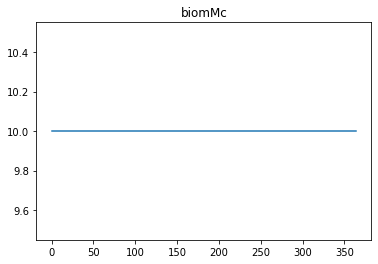

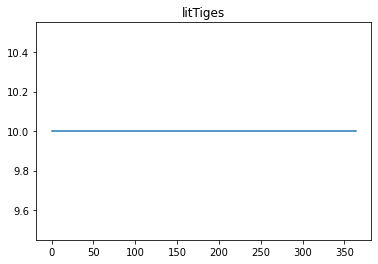

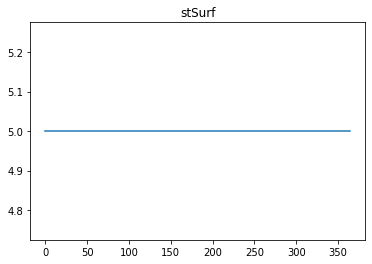

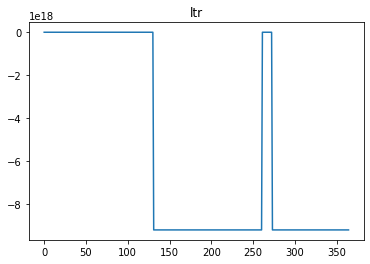

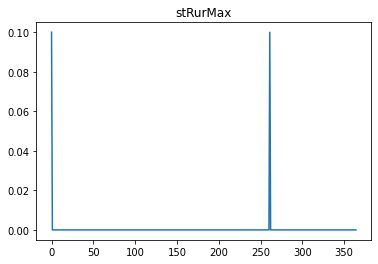

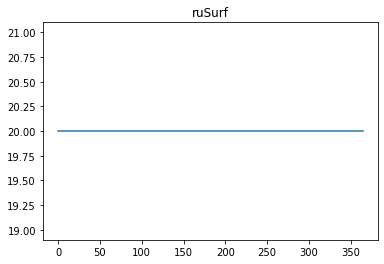

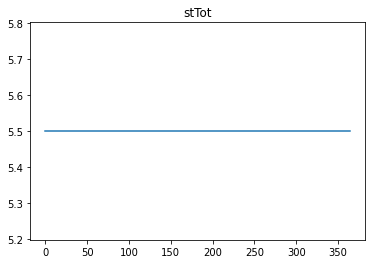

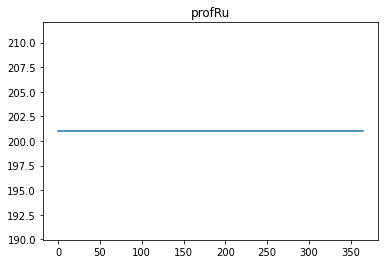

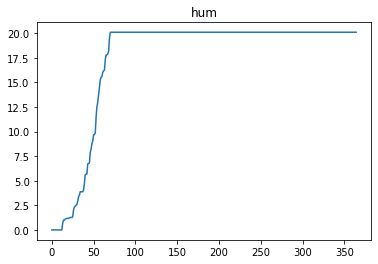

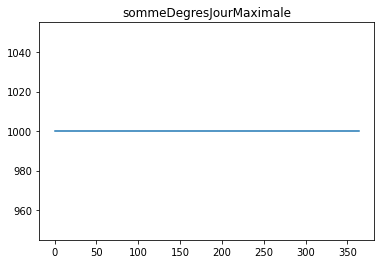

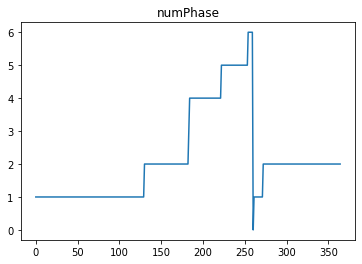

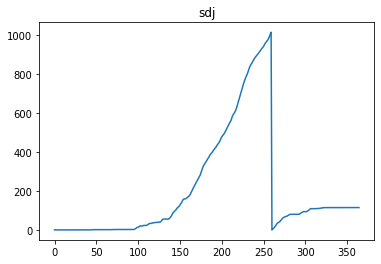

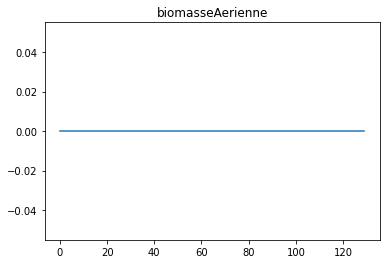

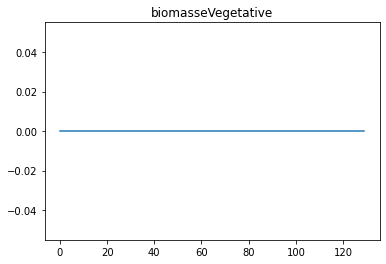

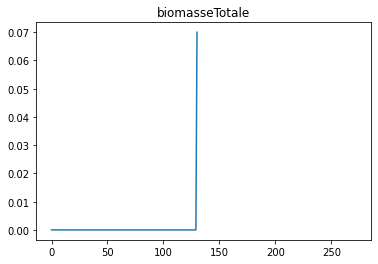

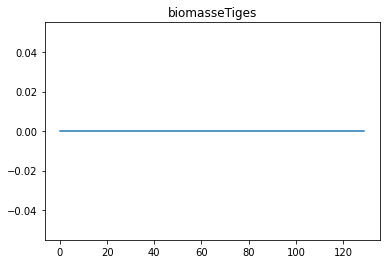

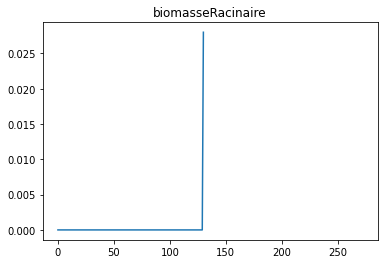

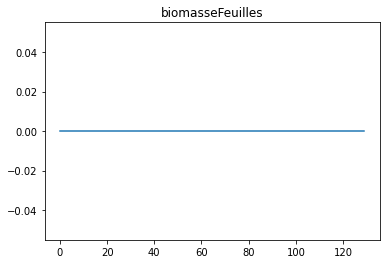

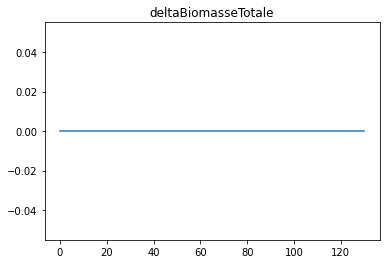

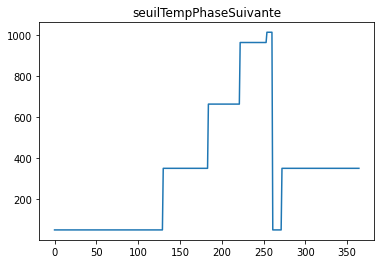

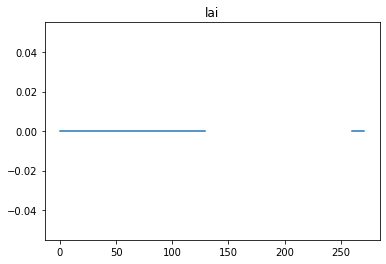

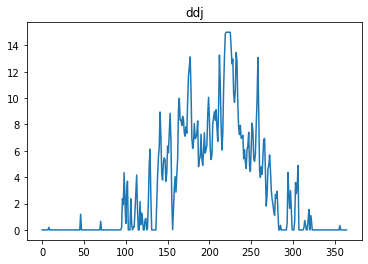

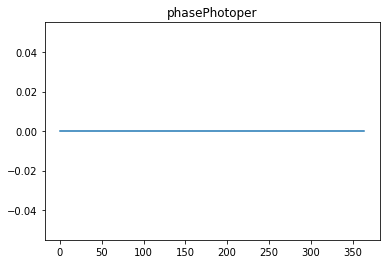

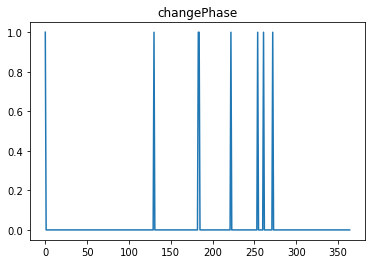

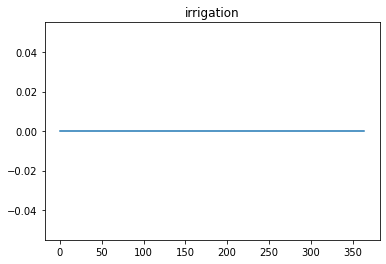

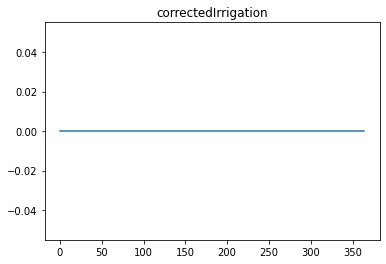

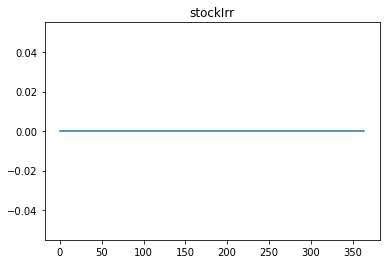

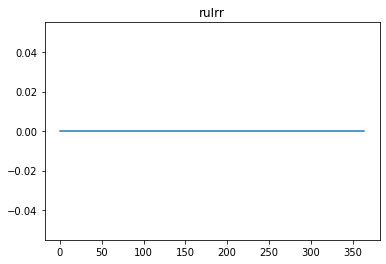

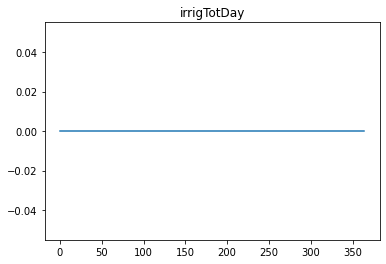

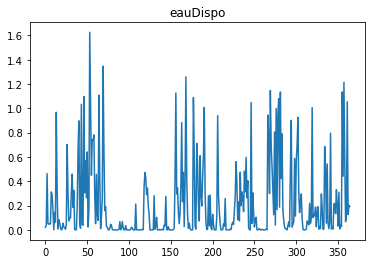

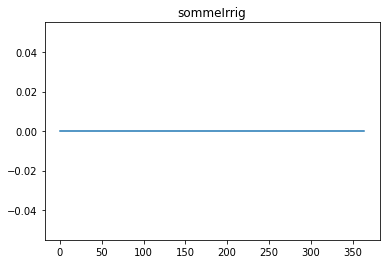

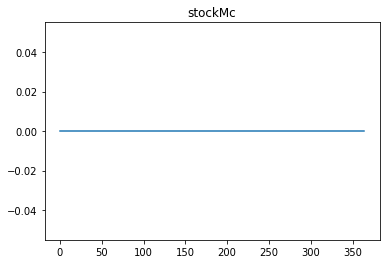

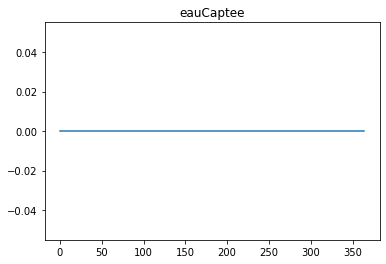

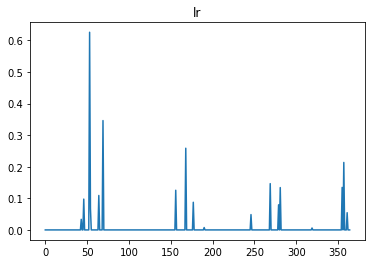

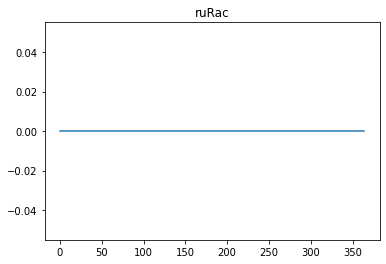

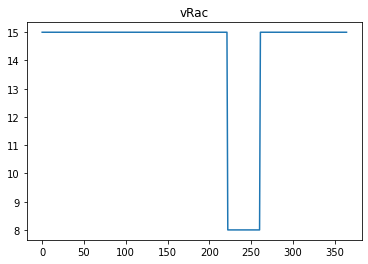

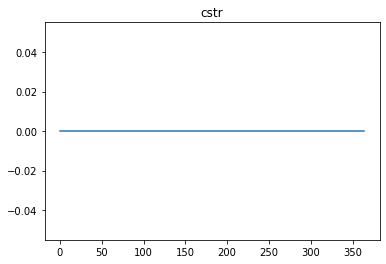

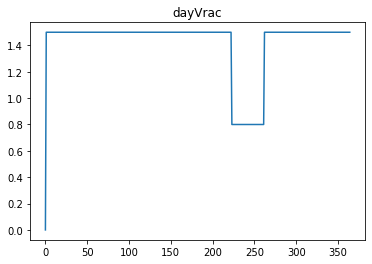

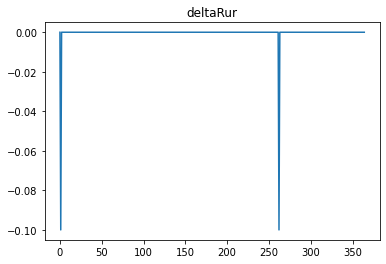

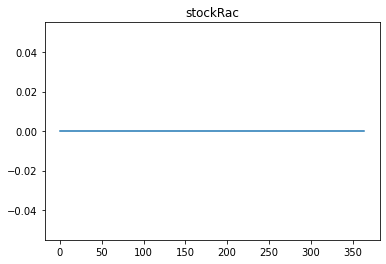

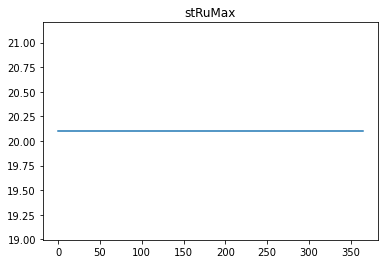

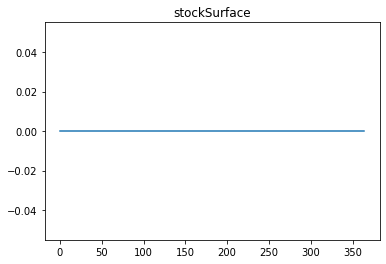

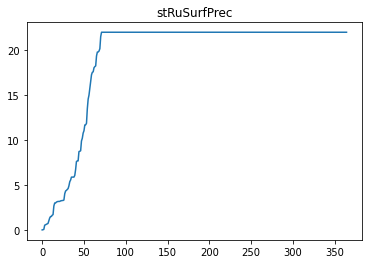

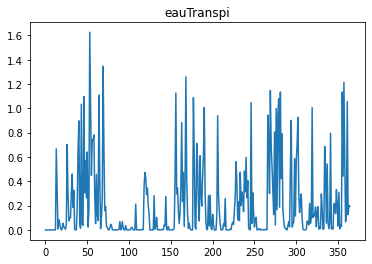

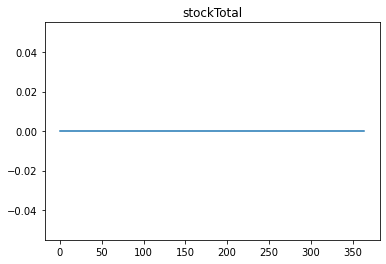

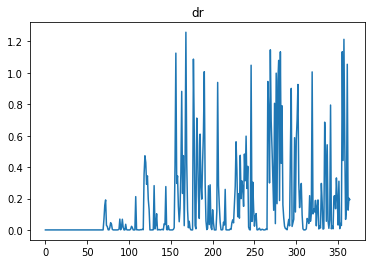

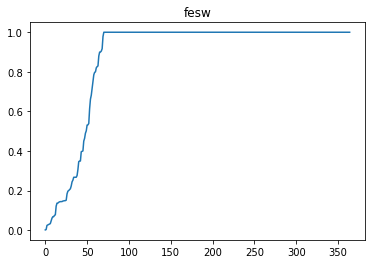

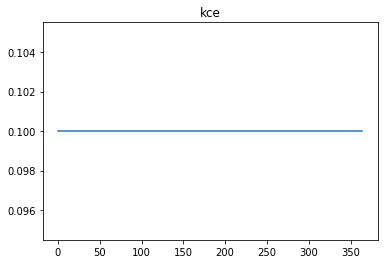

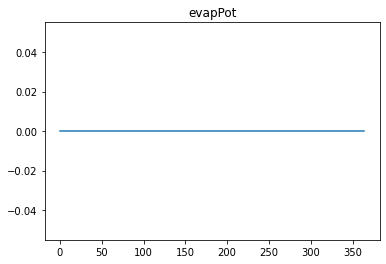

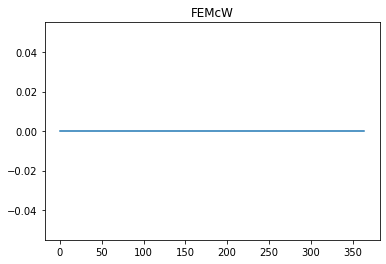

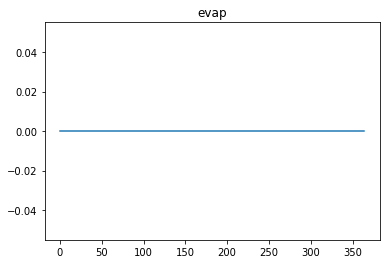

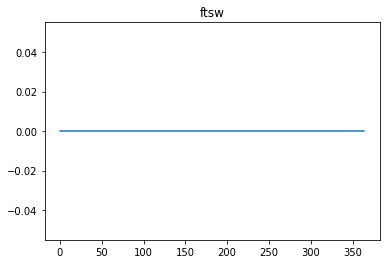

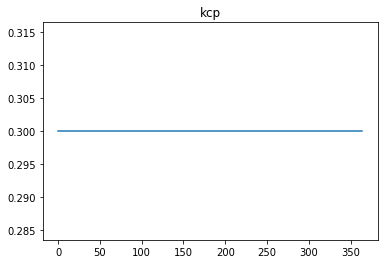

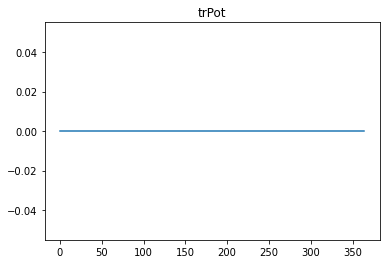

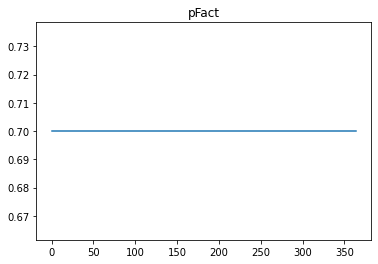

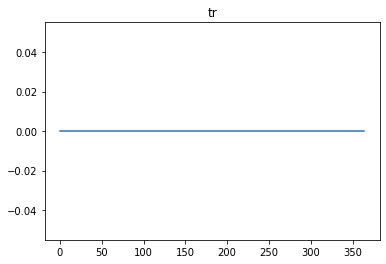

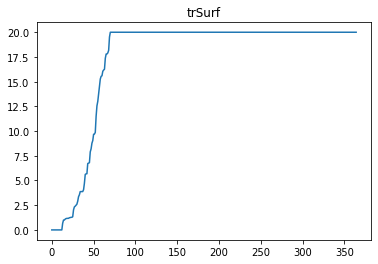

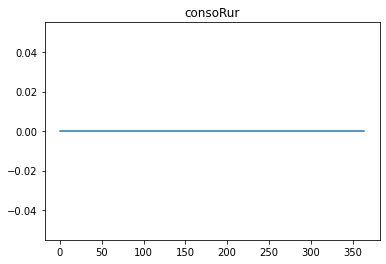

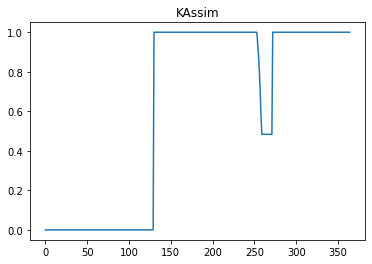

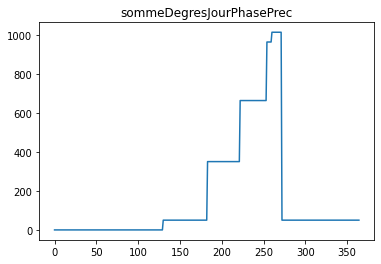

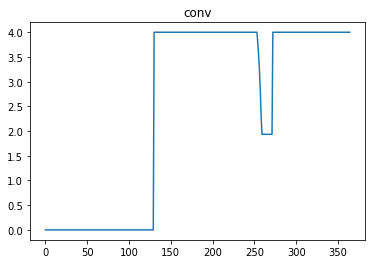

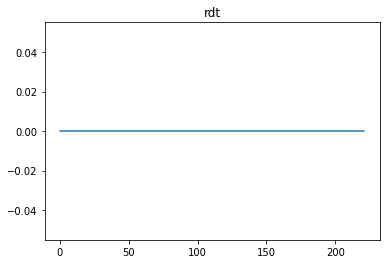

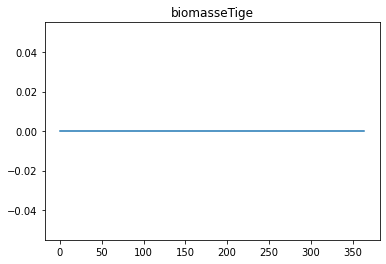

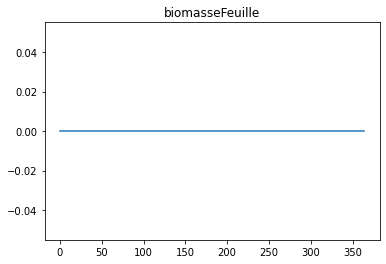

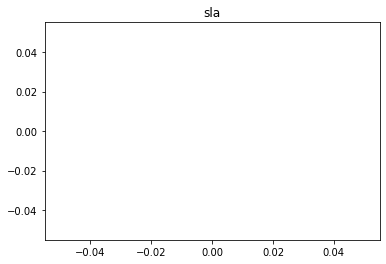

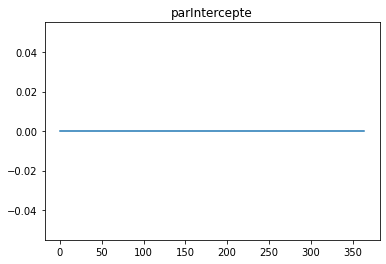

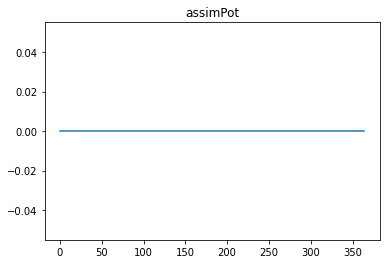

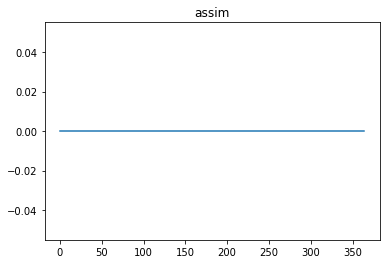

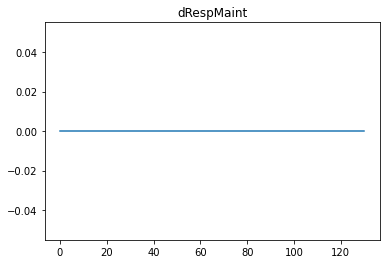

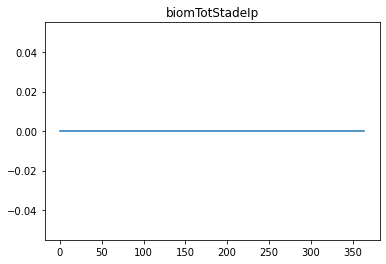

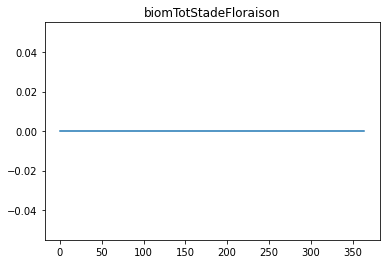

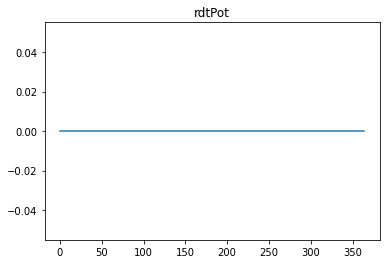

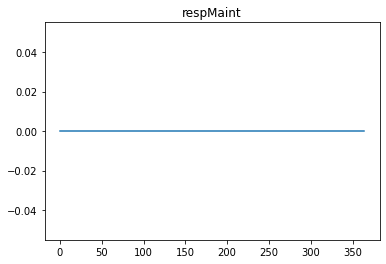

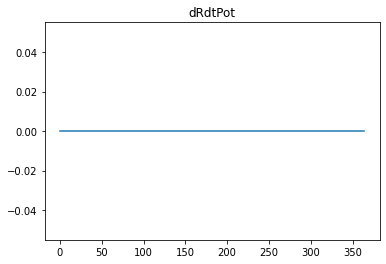

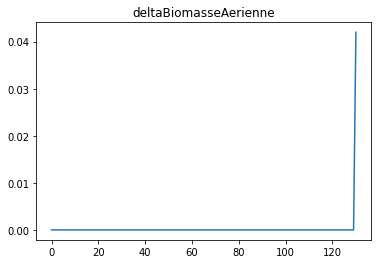

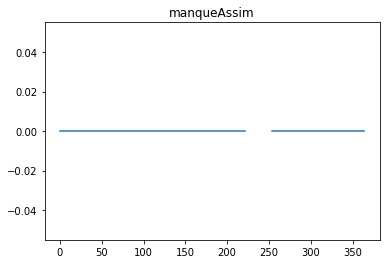

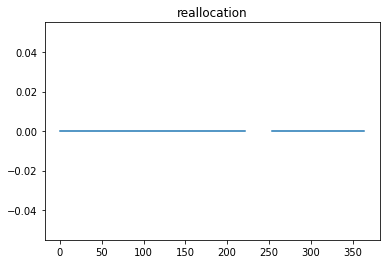

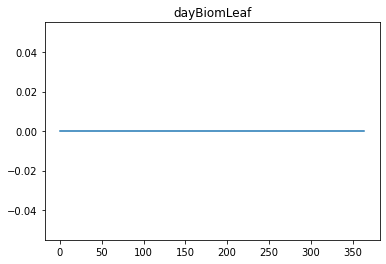

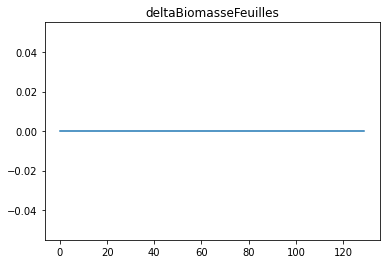

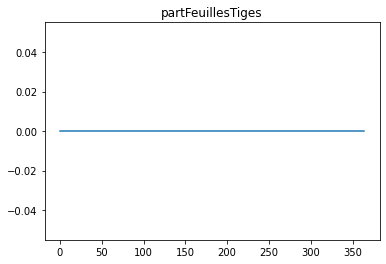

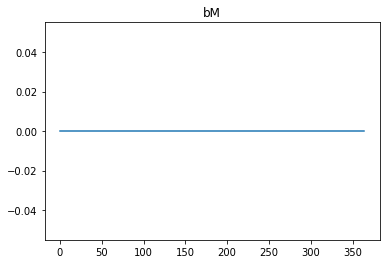

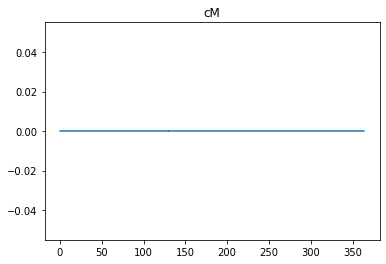

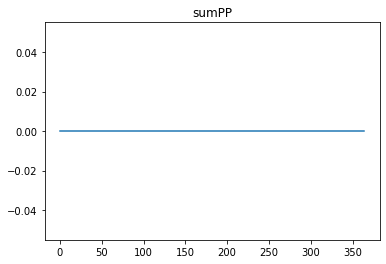

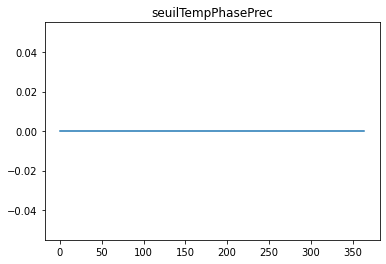

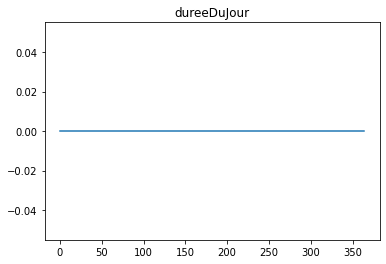

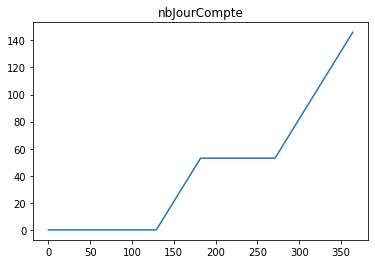

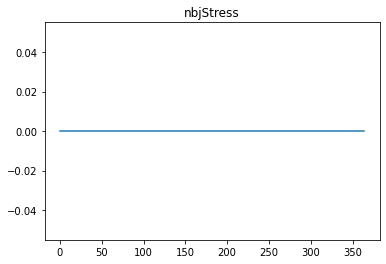

IndexError: invalid index to scalar variable.

In [289]:
for variable in list(data) :
    #print(variable)
    plt.plot(data[variable][0,0,:])
    plt.title(variable)
    plt.show()